### ISYE 6414 – Regression Analysis
#### Group 28 Final Project Report
##### Glistening Phoenixes
###### Approach 3: A Re-Evaluation of the Factors Impacting Housing Prices: A US State Study
Terence Buttrick

In [1]:
# lists all packages needed in this notebook
packages_list = list('ggplot2', 'corrplot', 'glmnet', 'lars', 'tidyverse', 'GGally',
                  'ggplot2', 'gglasso', 'caret', 'here', 'car', 'grpreg', 'scales', 'olsrr', 'plm', 'dplyr')
# checks to see if package is installed.  If not, installs and loads it
for (i in packages_list) {
  if (!require(i, character.only=TRUE)) install.packages(i, character.only=TRUE); library(i, character.only=TRUE)
}
# Set colors
gtblue = rgb(0, 48, 87, maxColorValue = 255)
techgold = rgb(179, 163, 105, maxColorValue = 255)
buzzgold = rgb(234, 190, 0, maxColorValue = 255)
bobbyjones = rgb(55, 113, 23, maxColorValue = 255)

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Loading required package: corrplot

corrplot 0.95 loaded

Loading required package: glmnet

Warning message:
"package 'glmnet' was built under R version 4.2.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.2"
Loaded glmnet 4.1-8

Loading required package: lars

Loaded lars 1.3


Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.2"
Warning message:
"package 'readr' was built under R version 4.2.2"
Warning message:
"package 'purrr' was built under R version 4.2.2"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built unde

### Data Preparation

There are 15402 observations in the data

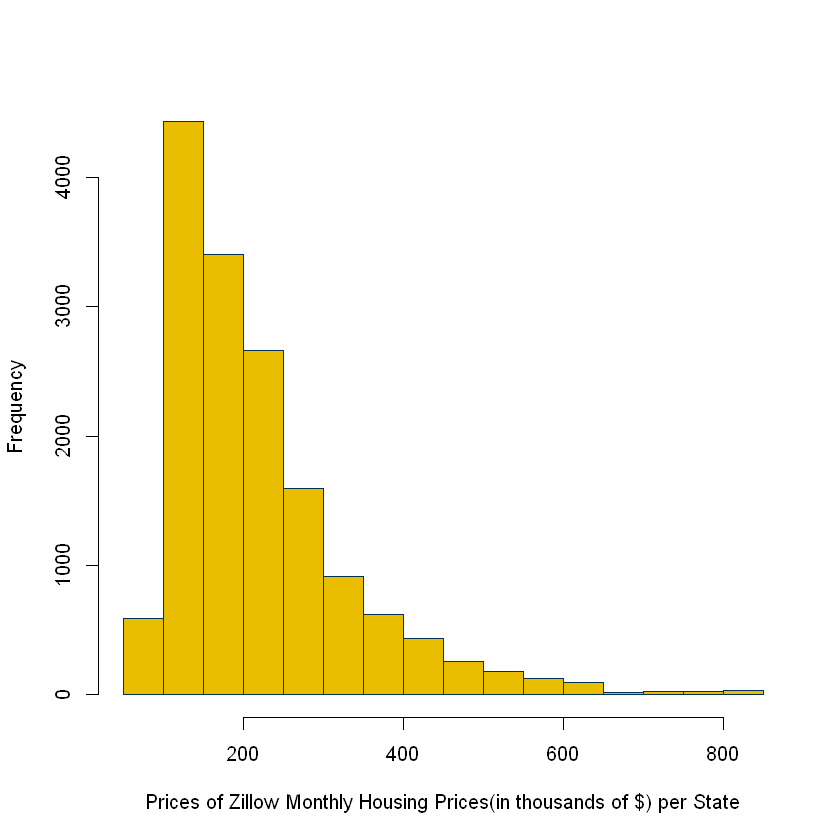

In [5]:
#read in the data file
dataHouse <- read.csv("everything.csv", header=TRUE)
dataHouse$Overall.Homeless = as.numeric(dataHouse$Overall.Homeless)
dataHouse$Sheltered.ES.Homeless = as.numeric(dataHouse$Sheltered.ES.Homeless)
dataHouse$Sheltered.TH.Homeless = as.numeric(dataHouse$Sheltered.TH.Homeless)
dataHouse$Sheltered.Total.Homeless = as.numeric(dataHouse$Sheltered.Total.Homeless)
dataHouse$Unsheltered.Homeless = as.numeric(dataHouse$Unsheltered.Homeless)
dataHouse$Sheltered.SH.Homeless = as.numeric(dataHouse$Sheltered.SH.Homeless)
dataHouse$CPI_Rent = as.numeric(dataHouse$CPI_Rent)
dataHouse$ZHVI_adj = as.numeric(dataHouse$ZHVI/1000) #Just makes it easier to read for graphics
#convert date to Date format
dataHouse$date <- as.Date(dataHouse$date, format="%Y-%m-%d")
#convert RegionName to factor:
dataHouse$RegionName <- as.factor(dataHouse$RegionName)

#show the number of observations
obs = nrow(dataHouse)
cat("There are", obs, "observations in the data")

#response Data Distribution

#check the distribution of the response
hist(dataHouse$ZHVI_adj,
     main="",
     xlab="Prices of Zillow Monthly Housing Prices(in thousands of $) per State", 
     border=gtblue,
     col=buzzgold)

There is definitely a right skewed nature to the dataset with a long right-hand tail. It will need some addressing later.

In [6]:
#Thanks to Oihana on approach 2, we copy her approach to clean the homelessness data:
# https://stackoverflow.com/questions/52221044/dplyrfirst-to-choose-first-non-na-value
df_hl <- dataHouse %>%
group_by(RegionName, date) %>%
summarize(
    avg_ZHVI = mean(ZHVI, na.rm = TRUE),

    Overall.Homeless = first(na.omit(Overall.Homeless)),
    Sheltered.ES.Homeless = first(na.omit(Sheltered.ES.Homeless)),
    Sheltered.TH.Homeless = first(na.omit(Sheltered.TH.Homeless)),
    Sheltered.Total.Homeless = first(na.omit(Sheltered.Total.Homeless)),
    Unsheltered.Homeless = first(na.omit(Unsheltered.Homeless)),
    Sheltered.SH.Homeless = first(na.omit(Sheltered.SH.Homeless)),

    .groups = 'drop'
    )

# make sheltered into a categorical variable
homeless_df <- df_hl %>%
pivot_longer(cols = c(Sheltered.ES.Homeless, Sheltered.TH.Homeless, Sheltered.SH.Homeless, Unsheltered.Homeless),
             names_to = 'Sheltered.Type',
             values_to = 'Sheltered.Type.Count')
# https://stackoverflow.com/questions/66736264/how-do-i-rename-values-of-a-variable-in-r
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.ES.Homeless'] = 'ES'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.TH.Homeless'] = 'TH'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.SH.Homeless'] = 'SH'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Unsheltered.Homeless'] = 'US'

homeless_df$Sheltered.Type <- as.factor(homeless_df$Sheltered.Type)

Now lets interrogate our variables:

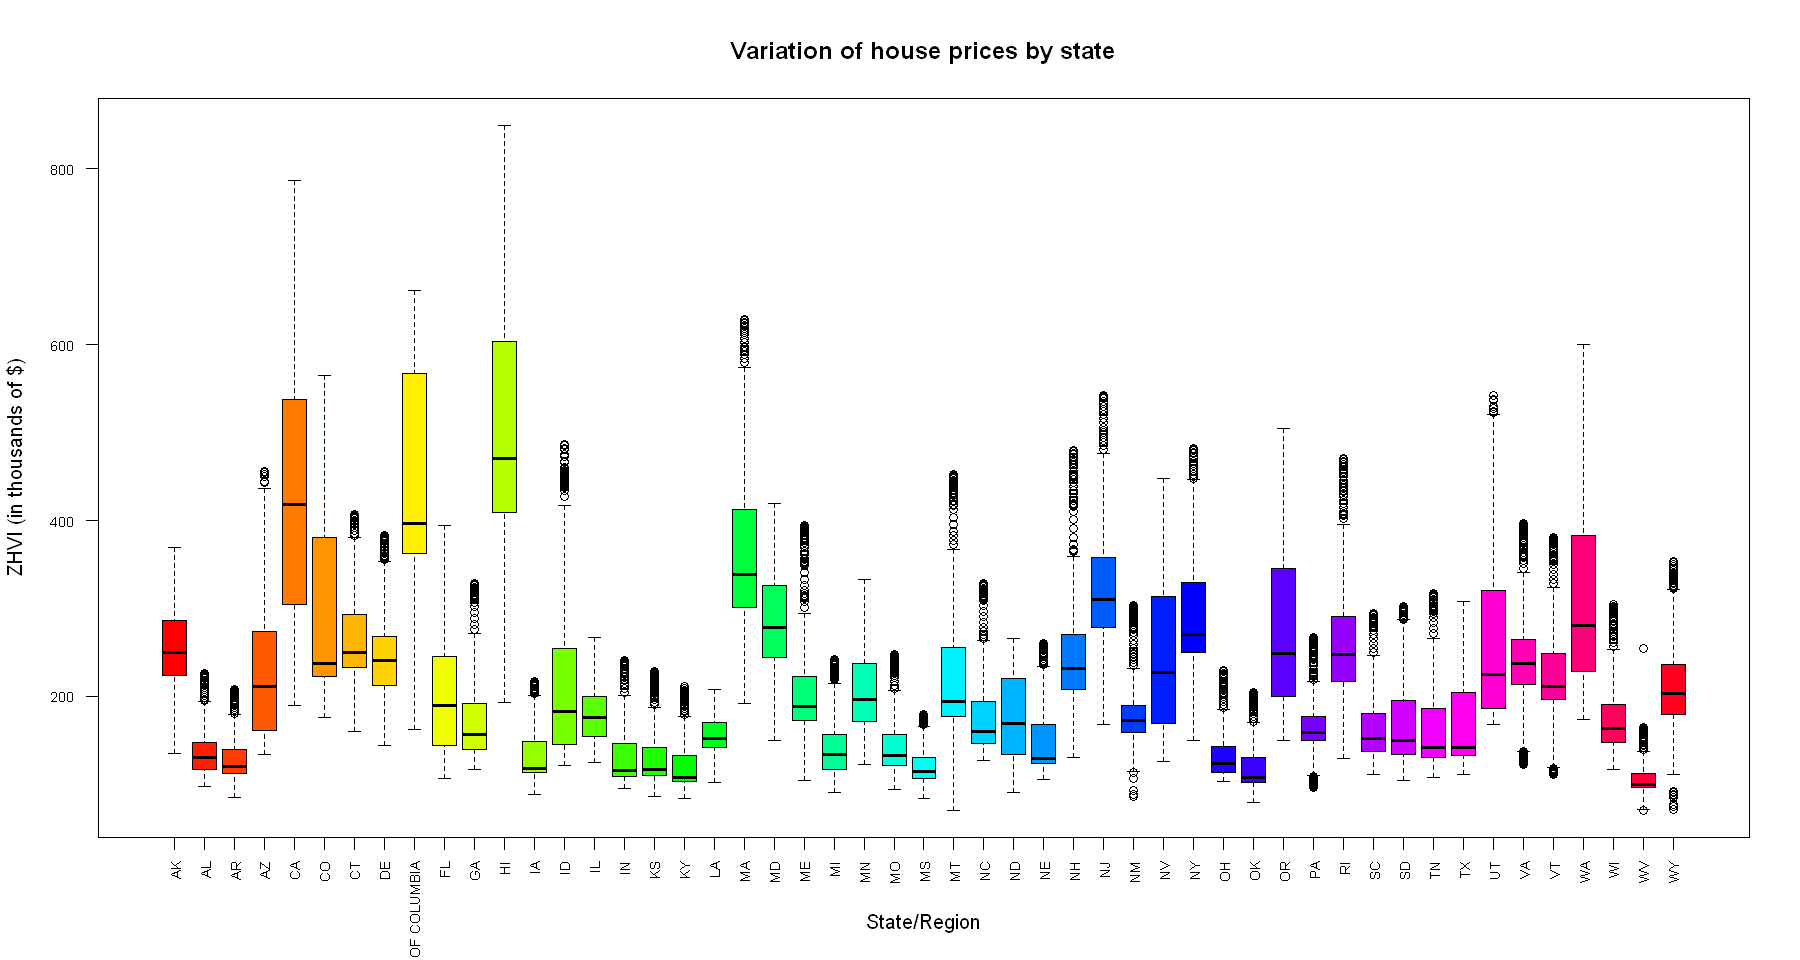

In [7]:
#Get avg ZHVI per month
df <- dataHouse %>%
group_by(year_month) %>%
summarize(avg_ZHVI_adj = mean(ZHVI_adj, na.rm = TRUE))

# Response variable vs categorical prediciting variables
options(repr.plot.width = 15, repr.plot.height = 8)


# Plot ZHVI variation across states
boxplot(ZHVI_adj ~ RegionName, data = dataHouse,
        main = "Variation of house prices by state",
        xlab = "State/Region", ylab = "ZHVI (in thousands of $)", 
        las = 2, cex.axis = 0.7,  col = rainbow(length(unique(dataHouse$RegionName)))) #Shoutout to Larry Phelps for the color scheme from approach 1
options(repr.plot.width = 10, repr.plot.height = 8)

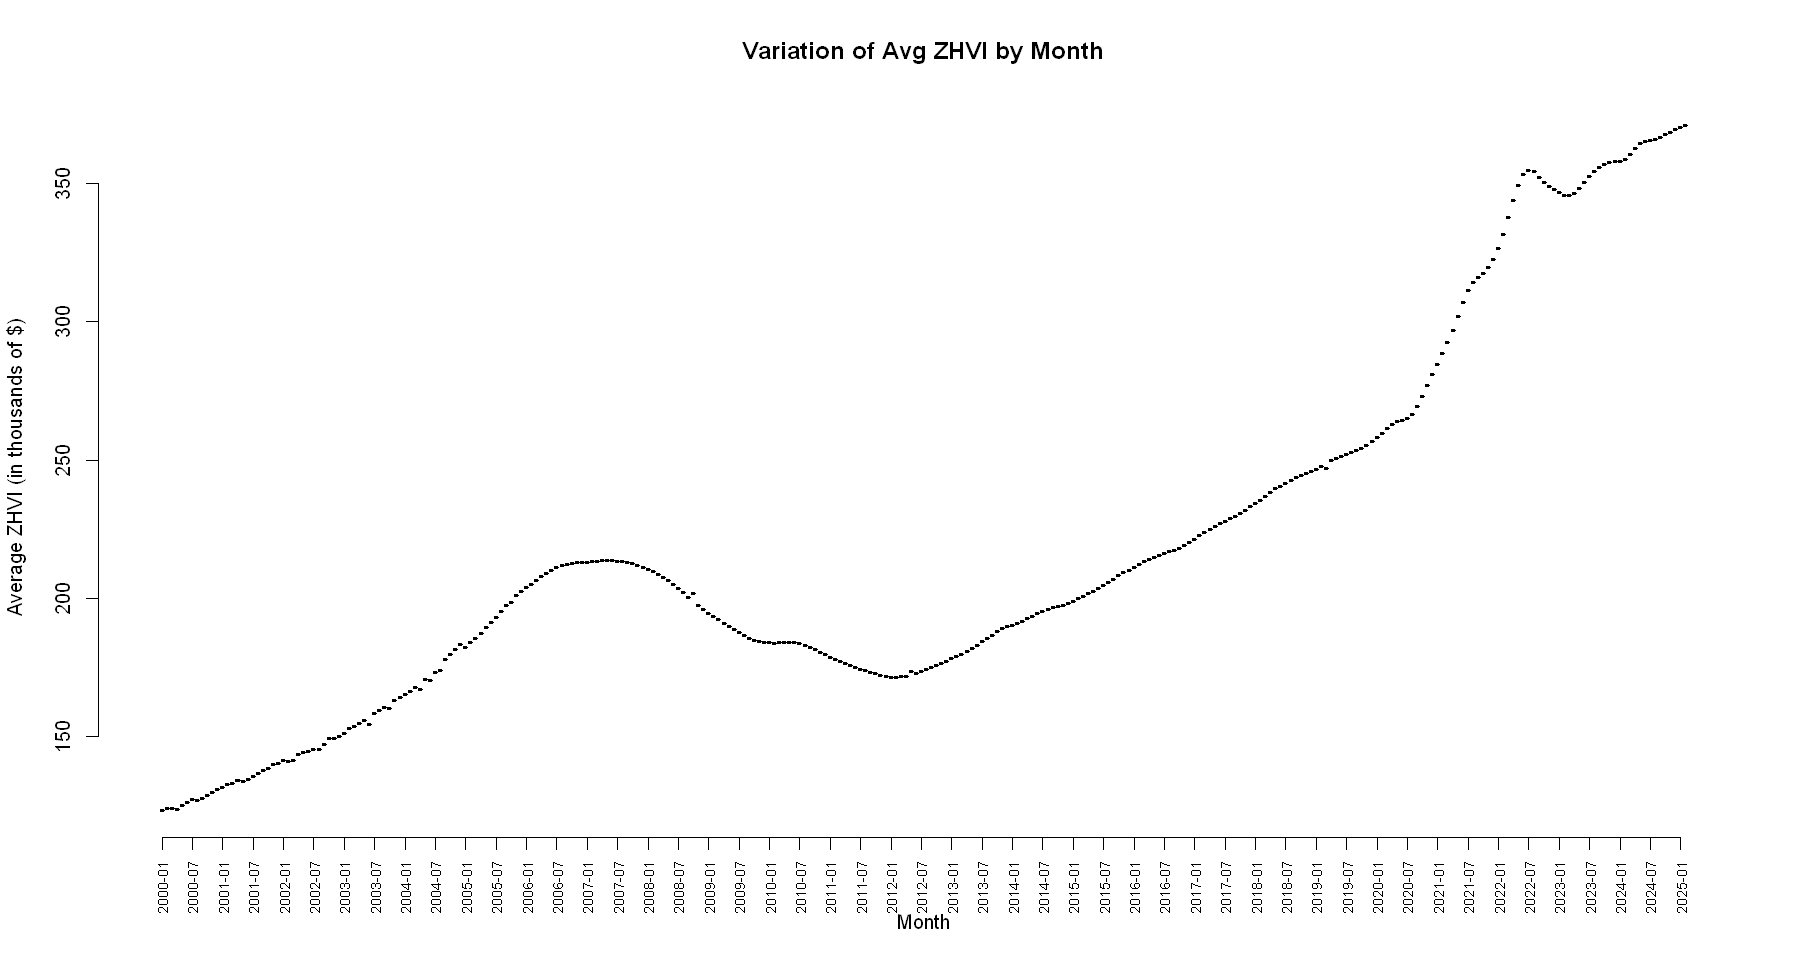

In [8]:
# plot over year
options(repr.plot.width = 15, repr.plot.height = 8)
        
boxplot(avg_ZHVI_adj ~ year_month, 
        data = df, 
        main = "Variation of Avg ZHVI by Month", 
        xlab = "Month", 
        ylab = "Average ZHVI (in thousands of $)", 
        axes = FALSE)
axis(2)
x_6m <- seq(1, length(unique(df$year_month)), by = 6)  # Every 6 months
axis(1, at = x_6m, labels = unique(df$year_month)[x_6m], las = 2, cex.axis = 0.7)

options(repr.plot.width = 10, repr.plot.height = 8)

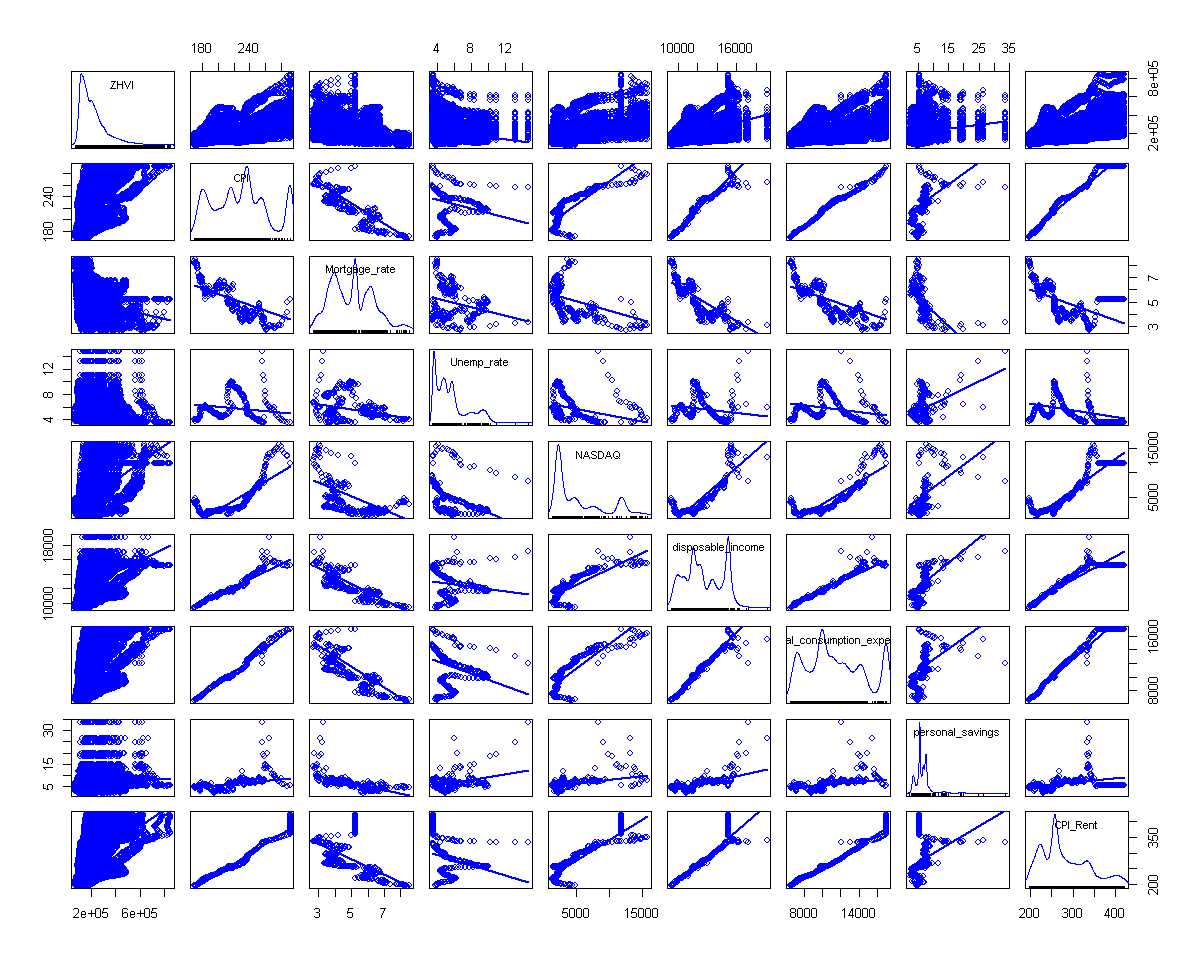

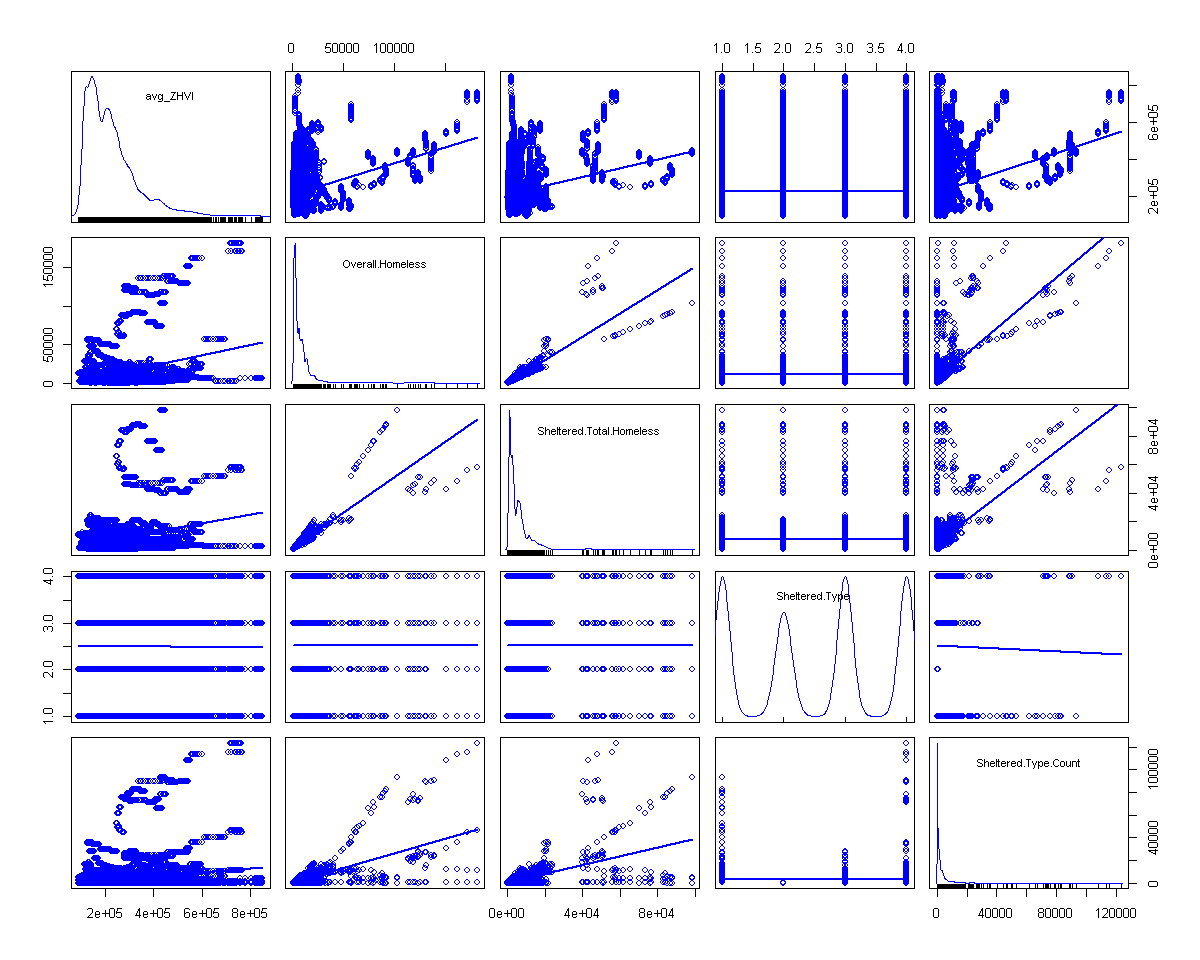

In [9]:
# Scatterplot matrix plots
par(mfrow=c(2,1))

# Old school Response vs Key economic indicator and short term rental CPI
scatterplotMatrix(~ ZHVI + CPI + Mortgage_rate + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings + CPI_Rent, data=dataHouse, smooth=FALSE)

# Response vs Homelessness variables
scatterplotMatrix(~ avg_ZHVI + Overall.Homeless+Sheltered.Total.Homeless+Sheltered.Type+Sheltered.Type.Count, data=homeless_df, smooth=FALSE)

[1] 10200

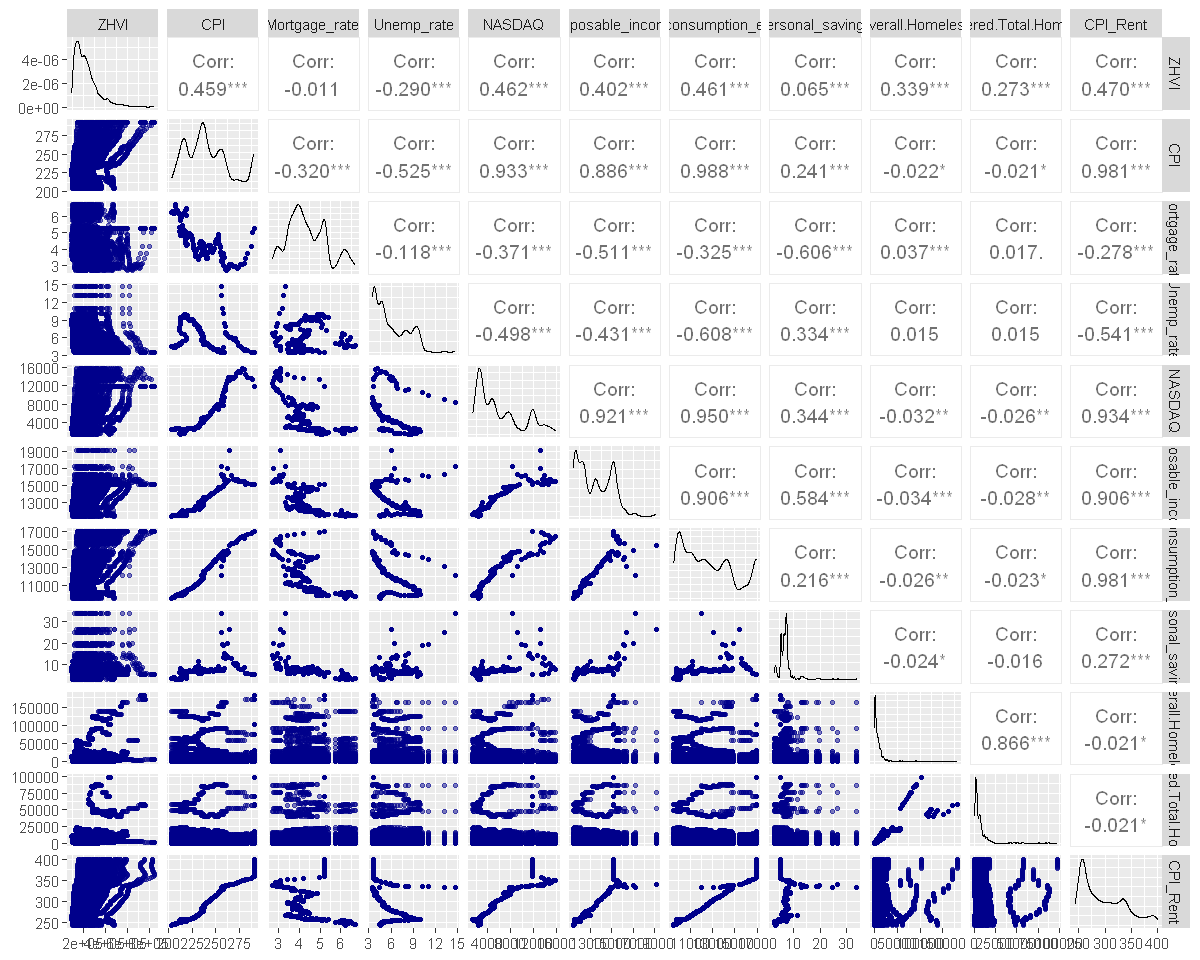

In [10]:
#Cool little corr plots
#https://www.r-bloggers.com/2021/06/ggpairs-in-r-a-brief-introduction-to-ggpairs/
library(dplyr)
data_GG <- dataHouse[, c("ZHVI", "CPI", "Mortgage_rate", "Unemp_rate", 
                             "NASDAQ", "disposable_income", 
                             "Personal_consumption_expenditure", 
                             "personal_savings", "Overall.Homeless", 
                             "Sheltered.Total.Homeless", "CPI_Rent")]
#Get rid of Na's
data_GG <- na.omit(data_GG)
nrow(data_GG)
ggpairs(data_GG,
        upper = list(continuous = wrap("cor", size = 4)),  
        lower = list(continuous = wrap("points", colour = "darkblue", alpha = 0.5, size = 1)), 
        diag = list(continuous = wrap("densityDiag")))

In [11]:
#Prep modelling data set
#select fields and remove Na's
dataModel <- dataHouse[,c(3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23, 25, 26, 27, 28, 29, 53, 684)]
dataModel <- na.omit(dataModel)

#Setup training split
trainData <- dataModel[dataModel$Year != '2023', ]
testData <- dataModel[dataModel$Year == '2023', ]

nrow(dataHouse)
nrow(dataModel)
nrow(trainData)
nrow(testData)

[1] 15402

[1] 8400

[1] 7800

[1] 600

### Modelling

#### Model 1: Basic Multiple Linear Regression (MLR)


In [12]:
## Creating the Models
# Create a multiple linear regression model (homeless fields based on model4 of approach2, thanks Oihana)
model_1 = lm(ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData)
m1_sum <- summary(model_1)
m1_sum


Call:
lm(formula = ZHVI ~ RegionName + CPI + Mortgage_rate + Unemp_rate + 
    NASDAQ + disposable_income + Personal_consumption_expenditure + 
    personal_savings + Unsheltered.Homeless + Overall.Homeless + 
    Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
    data = trainData)

Residuals:
   Min     1Q Median     3Q    Max 
-97249 -13676    504  13636 185475 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -6.408e+04  7.005e+04  -0.915 0.360289    
RegionNameAL                     -1.320e+05  3.270e+03 -40.372  < 2e-16 ***
RegionNameAR                     -1.470e+05  3.212e+03 -45.747  < 2e-16 ***
RegionNameAZ                     -3.107e+04  3.532e+03  -8.798  < 2e-16 ***
RegionNameCA                      2.904e+05  1.235e+04  23.510  < 2e-16 ***
RegionNameCO                      6.697e+04  3.524e+03  19.003  < 2e-16 ***
RegionNameCT                     -2.687e+04  3.224e+03  -8.335  < 2e-16 *

In [13]:
### Finding Insignificant Variables
as.data.frame(which(m1_sum$coeff[,4]>0.05))

,"which(m1_sum$coeff[, 4] > 0.05)"
,<int>
(Intercept),1
RegionNameNY,34
CPI,51
disposable_income,55
Personal_consumption_expenditure,56
personal_savings,57


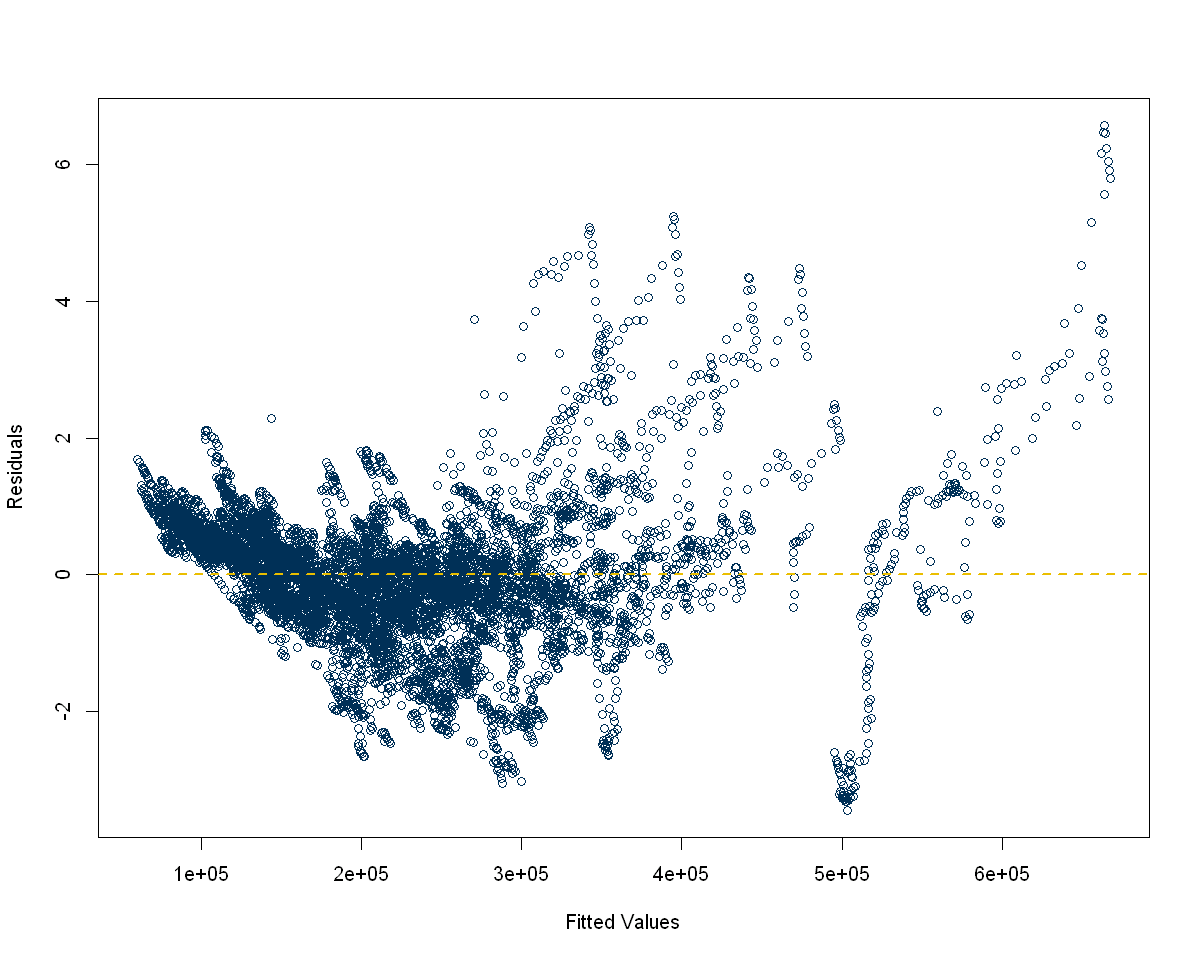

In [14]:
## Model Assessment: Multiple reg
### Constant Variance Assumption
# Extract the standardized residuals
resids1 = rstandard(model_1)
fits1 = model_1$fitted

# Plot the standardized residuals against
# fitted values
plot(fits1, resids1,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

The constant variance assumption does not hold -- the variance increases when moving from lower to higher fitted values. This can be refered to as megaphoning.Therefore, we use the BoxCox statistic to evaluate how we should transform our data. The lambda is rounded to -0.5 (so taking as zero). Therefore, a regression of the response logged will be tested.

3593 3592 
1711 1710

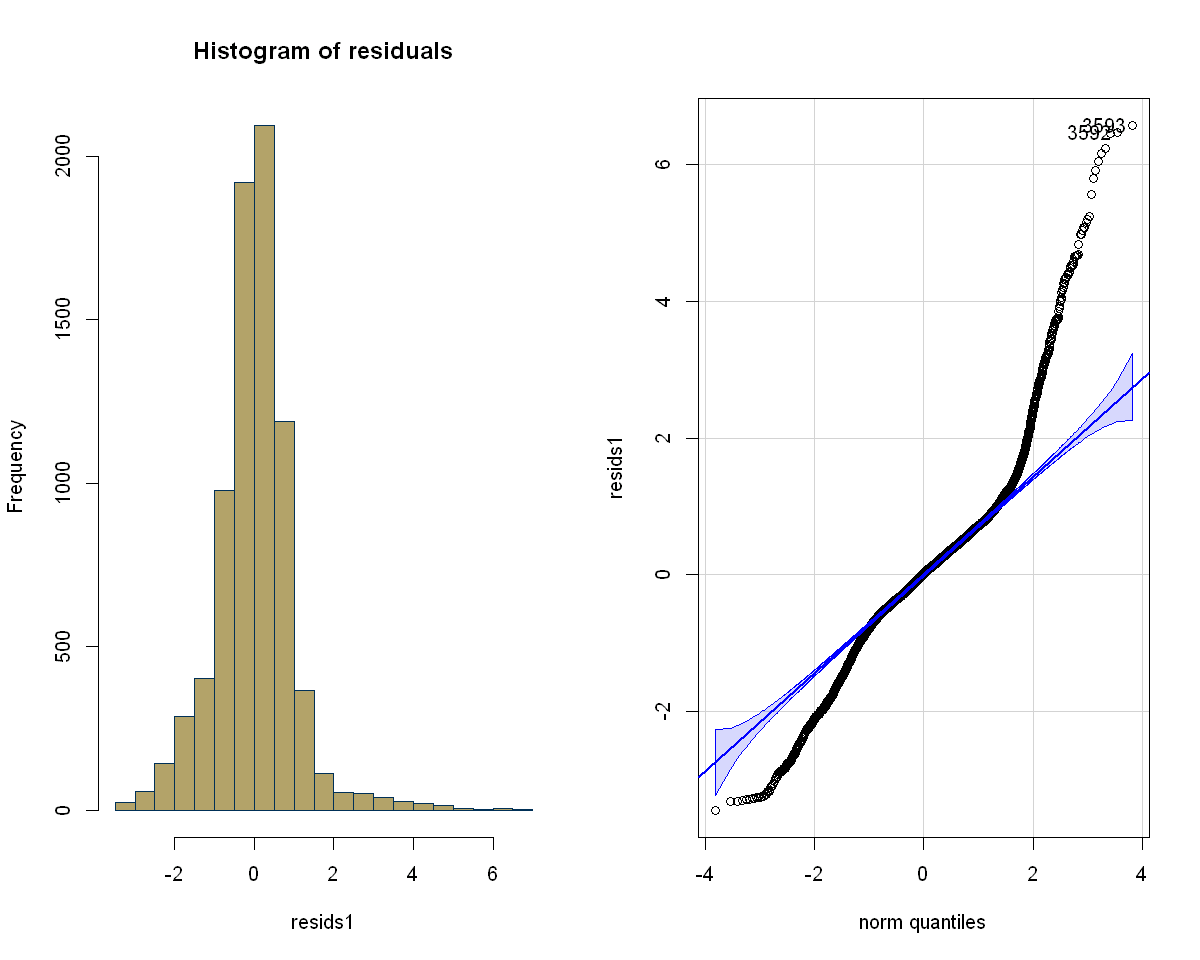

In [15]:
### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for Model 1
hist(resids1,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids1, envelope = 0.95)

Skewness abd very heavy tails. Hmm, this version doesn't look like it will work. Lets look at transforming the Y-variable using Box-Cox

#### Model 2: BoxCox transformed MLR

Optimal lambda:  -0.5 


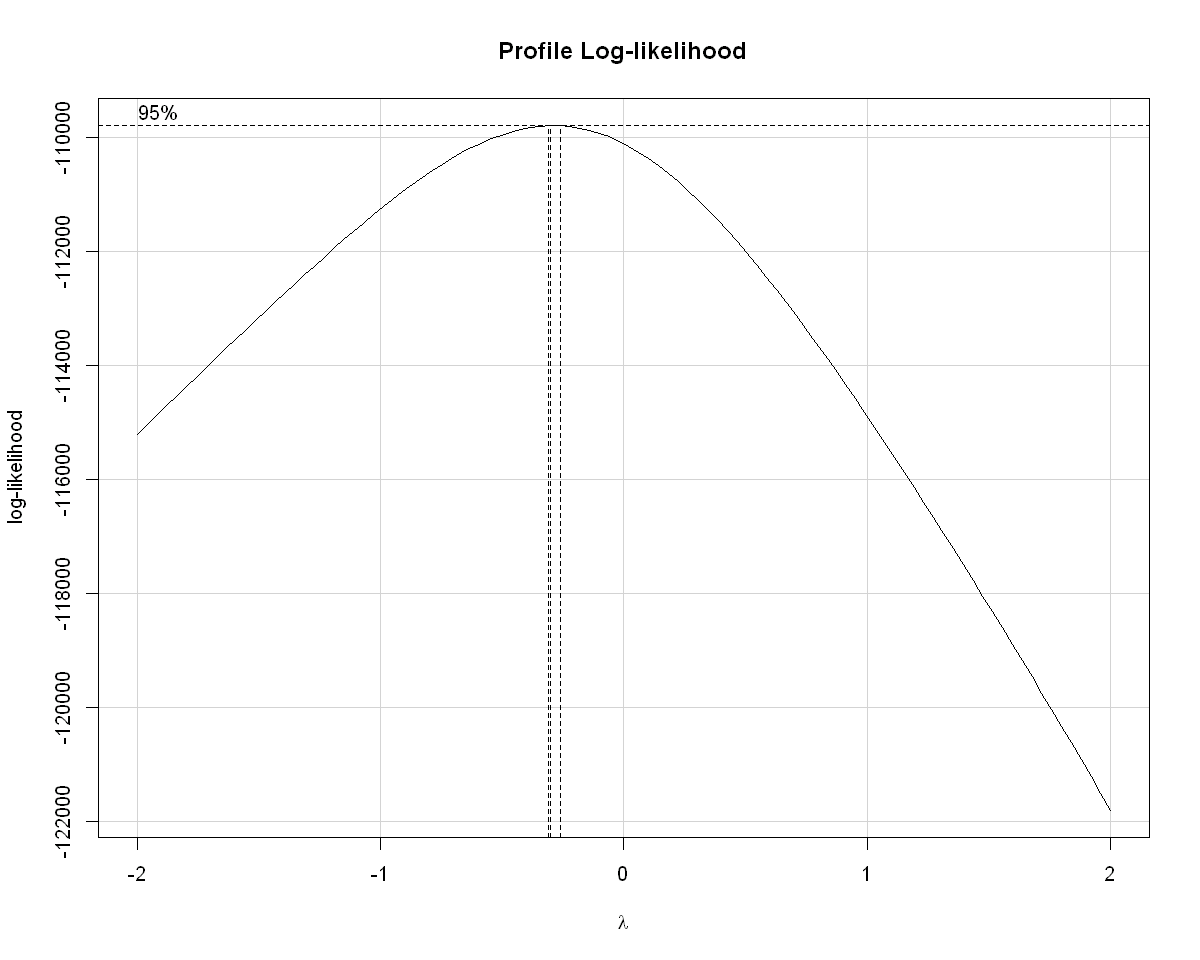

In [16]:
#Use BoxCox:
bc = boxCox(model_1)
opt.lambda = bc$x[which.max(bc$y)]
cat('Optimal lambda: ', round(opt.lambda/0.5) * 0.5, '\n')

Given the result is close to 0, the recommended action is to log ZHVI

In [17]:
#Hence we have model 2:
trainData$log_ZHVI <- log(trainData$ZHVI)
model_2 = lm(log_ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData)
m2_sum <- summary(model_2)
m2_sum


Call:
lm(formula = log_ZHVI ~ RegionName + CPI + Mortgage_rate + Unemp_rate + 
    NASDAQ + disposable_income + Personal_consumption_expenditure + 
    personal_savings + Unsheltered.Homeless + Overall.Homeless + 
    Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
    data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37511 -0.03912  0.00001  0.04128  0.39713 

Coefficients:
                                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                       1.102e+01  1.862e-01   59.202  < 2e-16 ***
RegionNameAL                     -6.506e-01  8.691e-03  -74.864  < 2e-16 ***
RegionNameAR                     -7.397e-01  8.538e-03  -86.636  < 2e-16 ***
RegionNameAZ                     -1.616e-01  9.387e-03  -17.214  < 2e-16 ***
RegionNameCA                      1.051e+00  3.284e-02   31.991  < 2e-16 ***
RegionNameCO                      1.949e-01  9.367e-03   20.805  < 2e-16 ***
RegionNameCT                     -9.436e-0

In [18]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_2)$coeff[,4]>0.05))

,"which(summary(model_2)$coeff[, 4] > 0.05)"
,<int>
RegionNameUT,44
CPI,51
disposable_income,55
Personal_consumption_expenditure,56
personal_savings,57
Sheltered.TH.Homeless,61


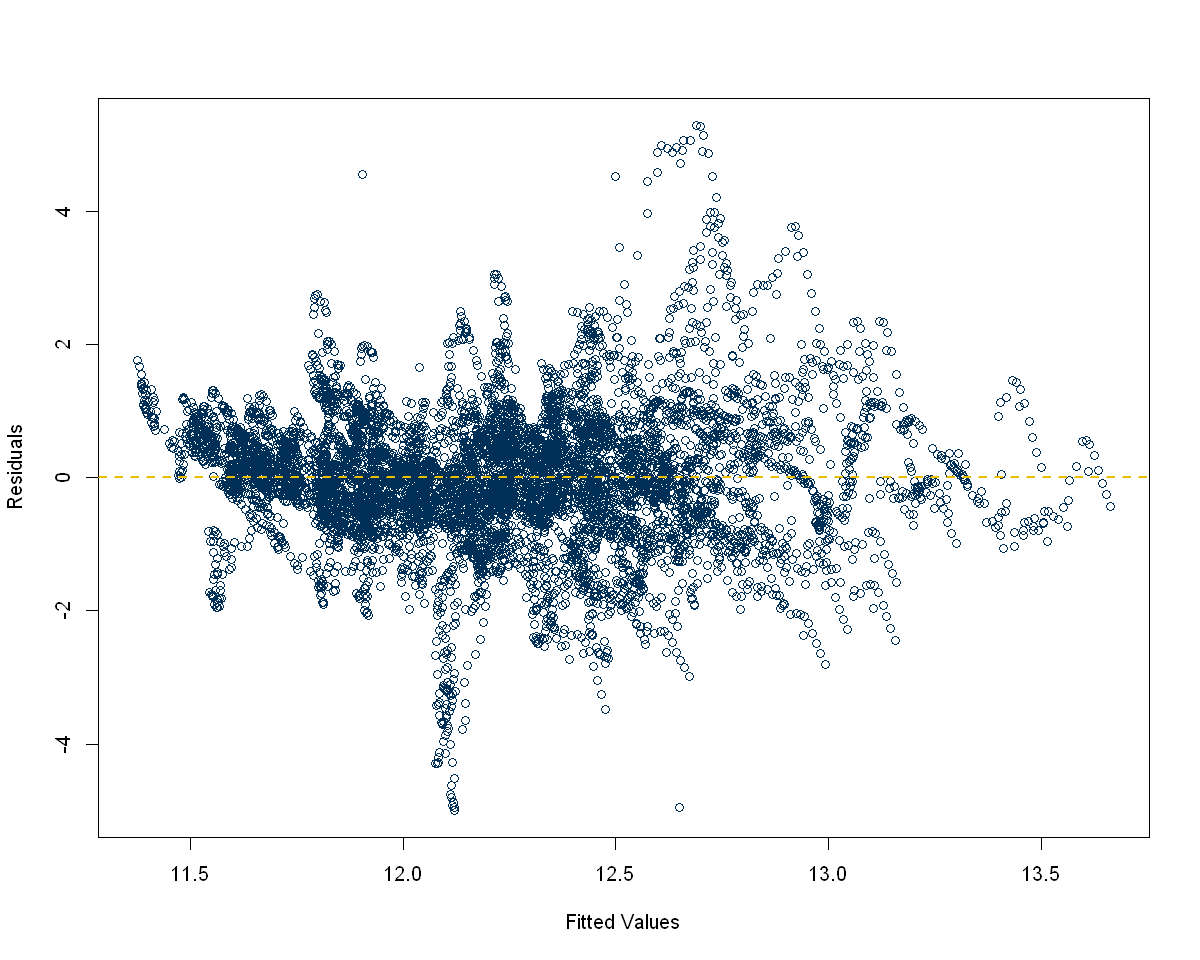

In [19]:
#Lets check its Goodness-of-fit:
### Constant Variance Assumption
# Extract the standardized residuals
resids2 = rstandard(model_2)
fits2 = model_2$fitted

options(repr.plot.width = 10, repr.plot.height = 8)
# Plot the standardized residuals against
# fitted values

plot(fits2, resids2,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

Much better but looks like some outliers

4195 4196 
2021 2022

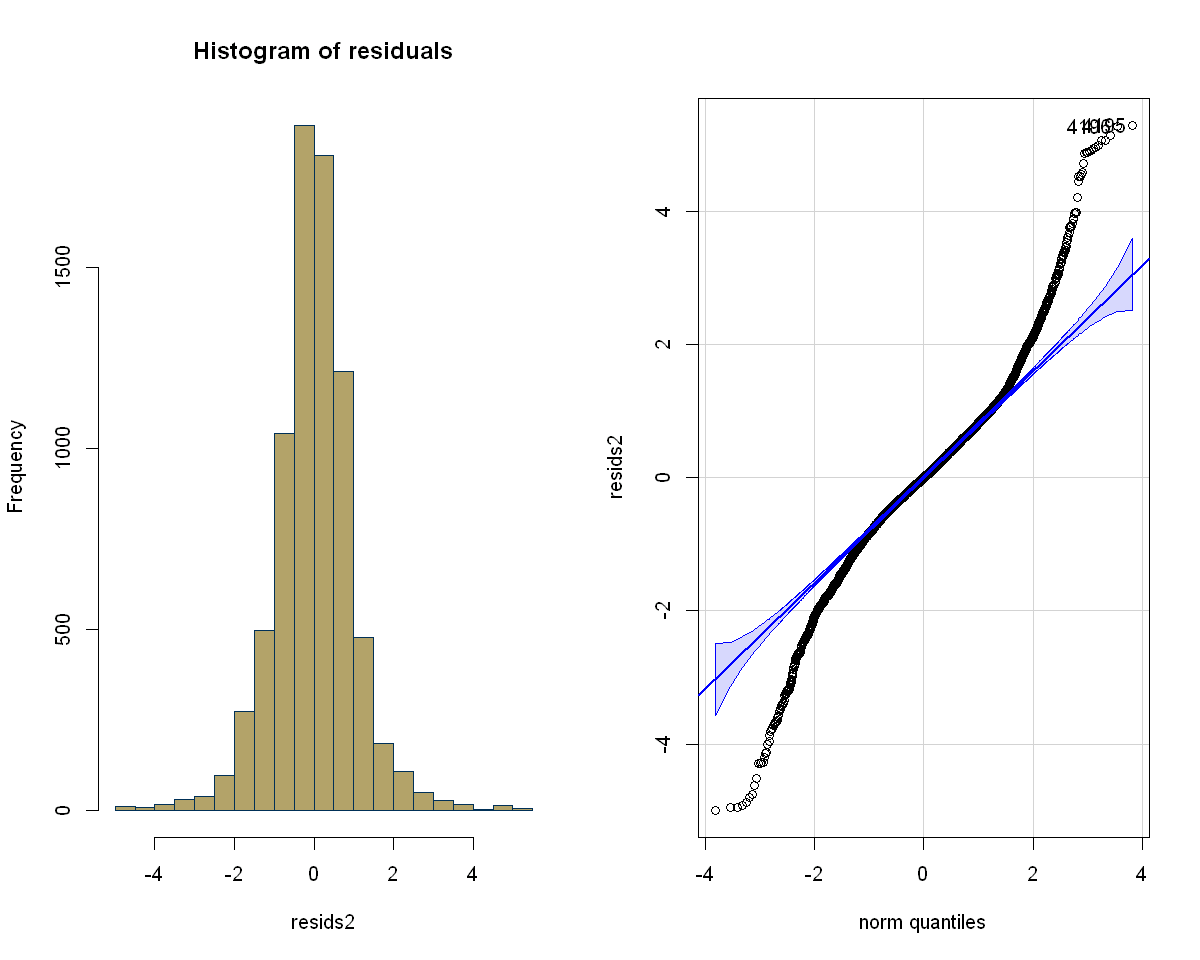

In [20]:
### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids2,
     nclass=20,
     col=techgold, 
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids2, envelope = 0.95)

The tails still departing the 45 degree line substantially in QQ-plot but we are much closer to a normal distribution looking at the histogram.

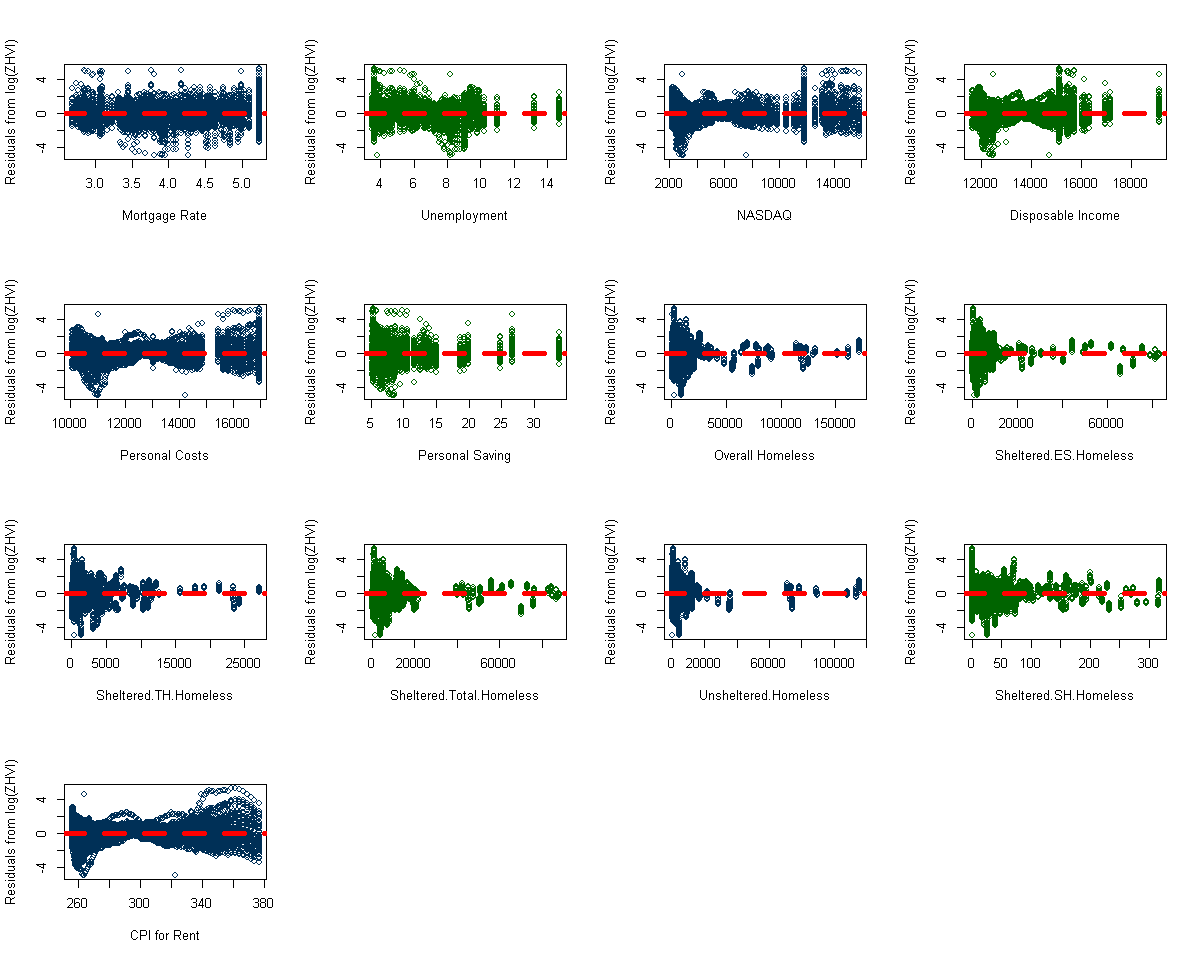

In [21]:
### Linearity Assumption
par(mfrow=c(4,4))
options(repr.plot.width = 10, repr.plot.height = 8)

# Plot the standardized residuals against numeric variables

plot(trainData$Mortgage_rate, resids2,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Unemp_rate, resids2,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$NASDAQ, resids2,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$disposable_income, resids2,
     xlab="Disposable Income",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Personal_consumption_expenditure, resids2,
     xlab="Personal Costs",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$personal_savings, resids2,
     xlab="Personal Saving",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Overall.Homeless, resids2,
     xlab="Overall Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.ES.Homeless, resids2,
     xlab="Sheltered.ES.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.TH.Homeless, resids2,
     xlab="Sheltered.TH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.Total.Homeless, resids2,
     xlab="Sheltered.Total.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Unsheltered.Homeless, resids2,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$Sheltered.SH.Homeless, resids2,
     xlab="Sheltered.SH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData$CPI_Rent, resids2,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

Relatively linear with values hovering around zero for all the variables. Model looking reasonably good but must be cautious with confidence intervals and prediction based on the tails on the QQplot. 

[1] "Cook's distance threshold: 0.000512820512820513"
[1] "Number of outliers: 473"


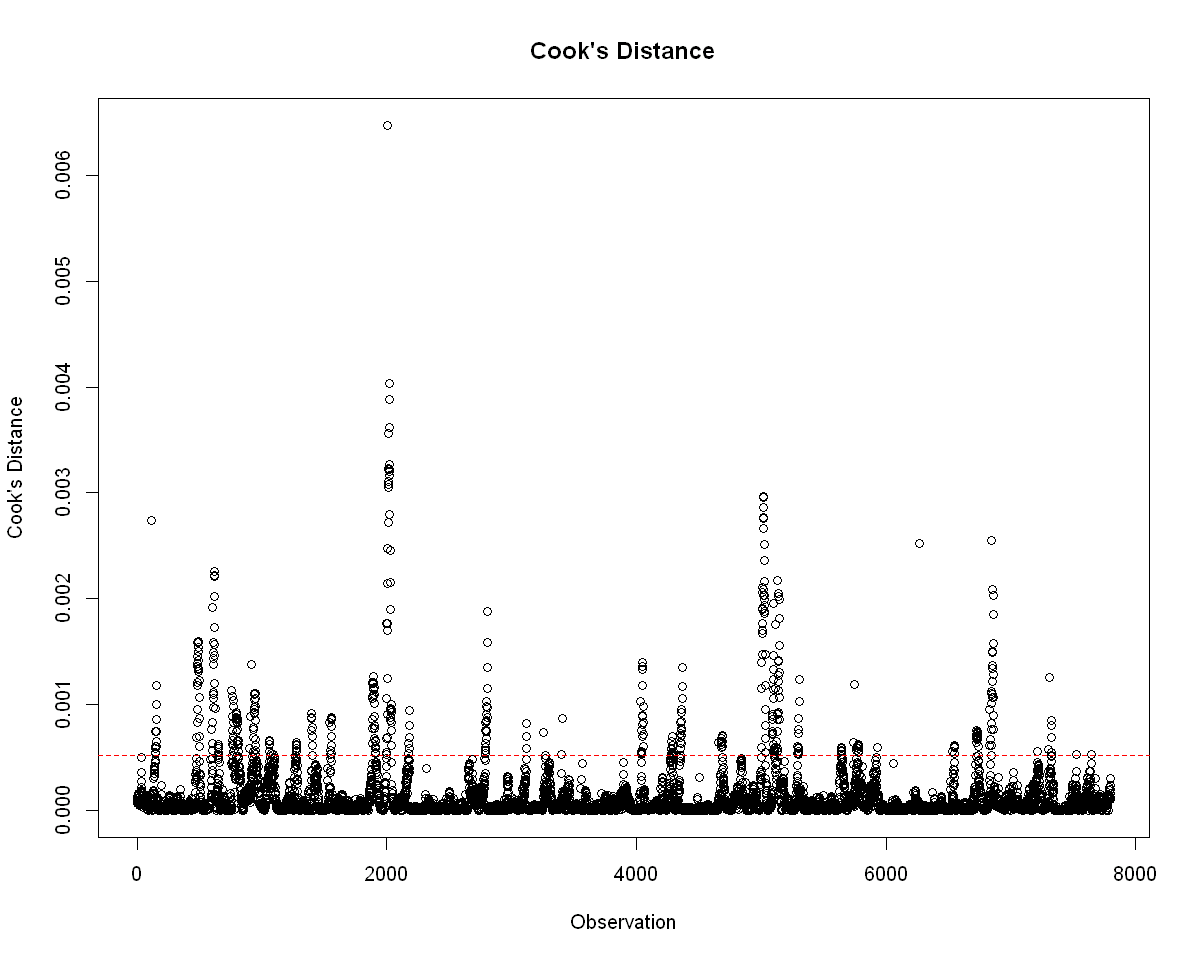

In [22]:
## Lets look at addressing outliers can help
# Calculate Cook's distances
model2_cook <- cooks.distance(model_2)

# Get the number of rows in the dataset used to create the model
cook_n <- nrow(model_2$model)

# Calculate threshold
cook_threshold <- 4 / cook_n

# Plot Cook's distances
plot(model2_cook, main = "Cook's Distance", ylab = "Cook's Distance", xlab = "Observation")
abline(h = cook_threshold, col = "red", lty = 2)

# Print the calculated threshold
print(paste("Cook's distance threshold:", cook_threshold))

# Identify outliers
outliers <- which(model2_cook > cook_threshold)

# Print the number of outliers
print(paste("Number of outliers:", length(outliers)))

# Output the highest 5 outlier rows from train_sales_data
highest_outliers <- order(model2_cook[outliers], decreasing = TRUE)[1:5]
outlier_rows <- trainData[outliers[highest_outliers], ]

In [23]:
outlier_year <- trainData[outliers, ] %>%
                group_by(Year) %>%
                summarise(outlier_count = n()) %>%
                arrange(Year)
outlier_year

Year,outlier_count
<int>,<int>
2010,44
2011,64
2012,61
2013,13
2015,5
2016,5
2018,12
2019,9
2020,23


As suspected there are alot and the majority are aggregated around Covid and the global financial crisis, indicating if we were looking at this from a time series perspective, that these periods are dislocations from the prevailing trends and drift. Based on empirical evidence (cited in report), it seems we can cut for the outliers as even as there are valid outliers, we will look to predict the market based on the 35-65 mark that the ZHVI uses.

#### Model 3: BoxCox transformed, outliers removed MLR

In [24]:
#Run reg without outliers as Model 3:
trainData_cook <- trainData[-outliers, ]
model_3 = lm(log_ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent,
            data=trainData_cook)
m3_sum <- summary(model_3)
m3_sum


Call:
lm(formula = log_ZHVI ~ RegionName + CPI + Mortgage_rate + Unemp_rate + 
    NASDAQ + disposable_income + Personal_consumption_expenditure + 
    personal_savings + Unsheltered.Homeless + Overall.Homeless + 
    Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
    data = trainData_cook)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.188314 -0.034647  0.000731  0.035241  0.187448 

Coefficients:
                                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                       1.153e+01  1.430e-01   80.663  < 2e-16 ***
RegionNameAL                     -6.574e-01  6.535e-03 -100.593  < 2e-16 ***
RegionNameAR                     -7.528e-01  6.389e-03 -117.828  < 2e-16 ***
RegionNameAZ                     -1.552e-01  7.643e-03  -20.311  < 2e-16 ***
RegionNameCA                      1.216e+00  2.749e-02   44.247  < 2e-16 ***
RegionNameCO                      2.187e-01  7.394e-03   29.578  < 2e-16 ***
RegionNameCT               

In [25]:
### Finding Insignificant Variables
as.data.frame(which(summary(model_3)$coeff[,4]>0.05))

,"which(summary(model_3)$coeff[, 4] > 0.05)"
,<int>
personal_savings,57


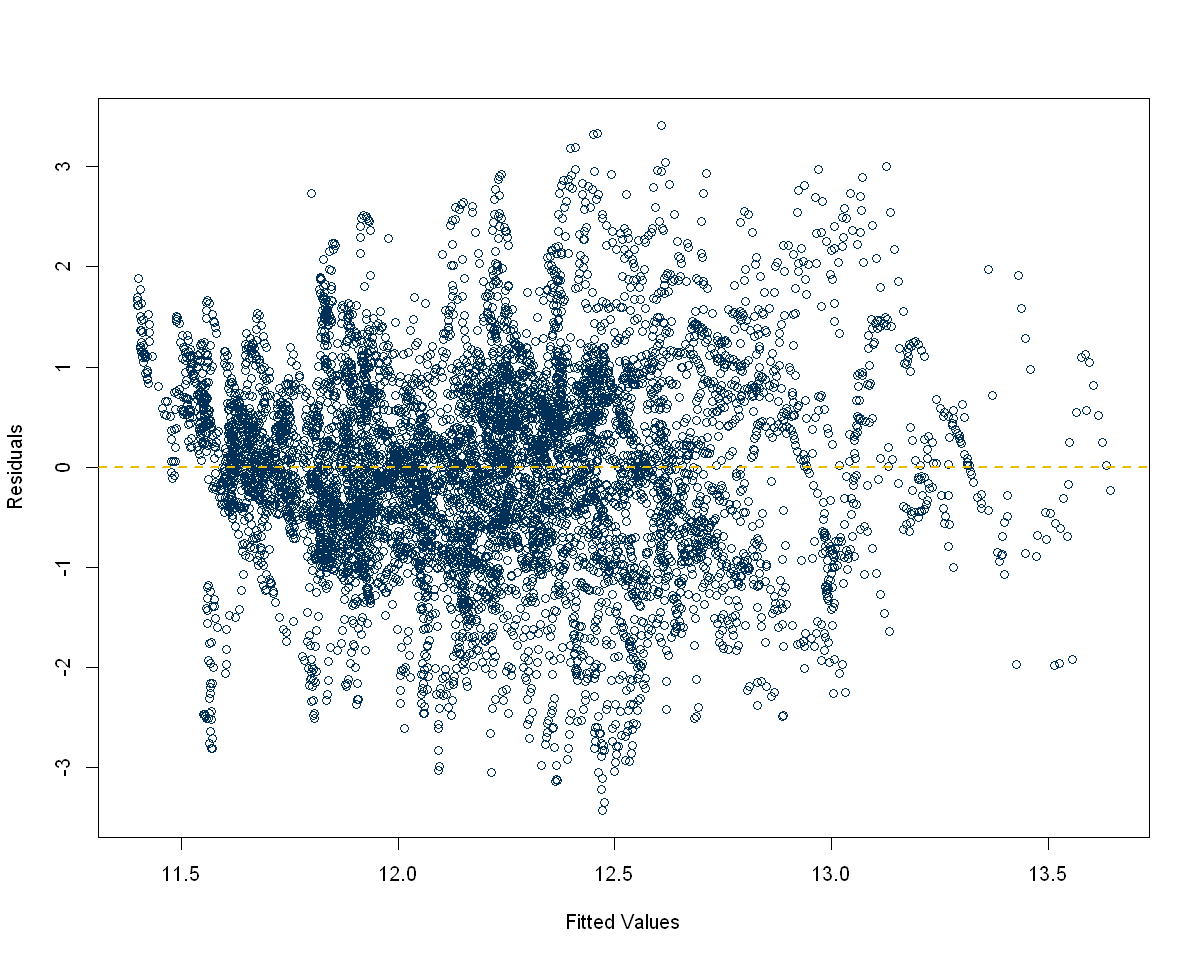

1661 8111 
 718 3787

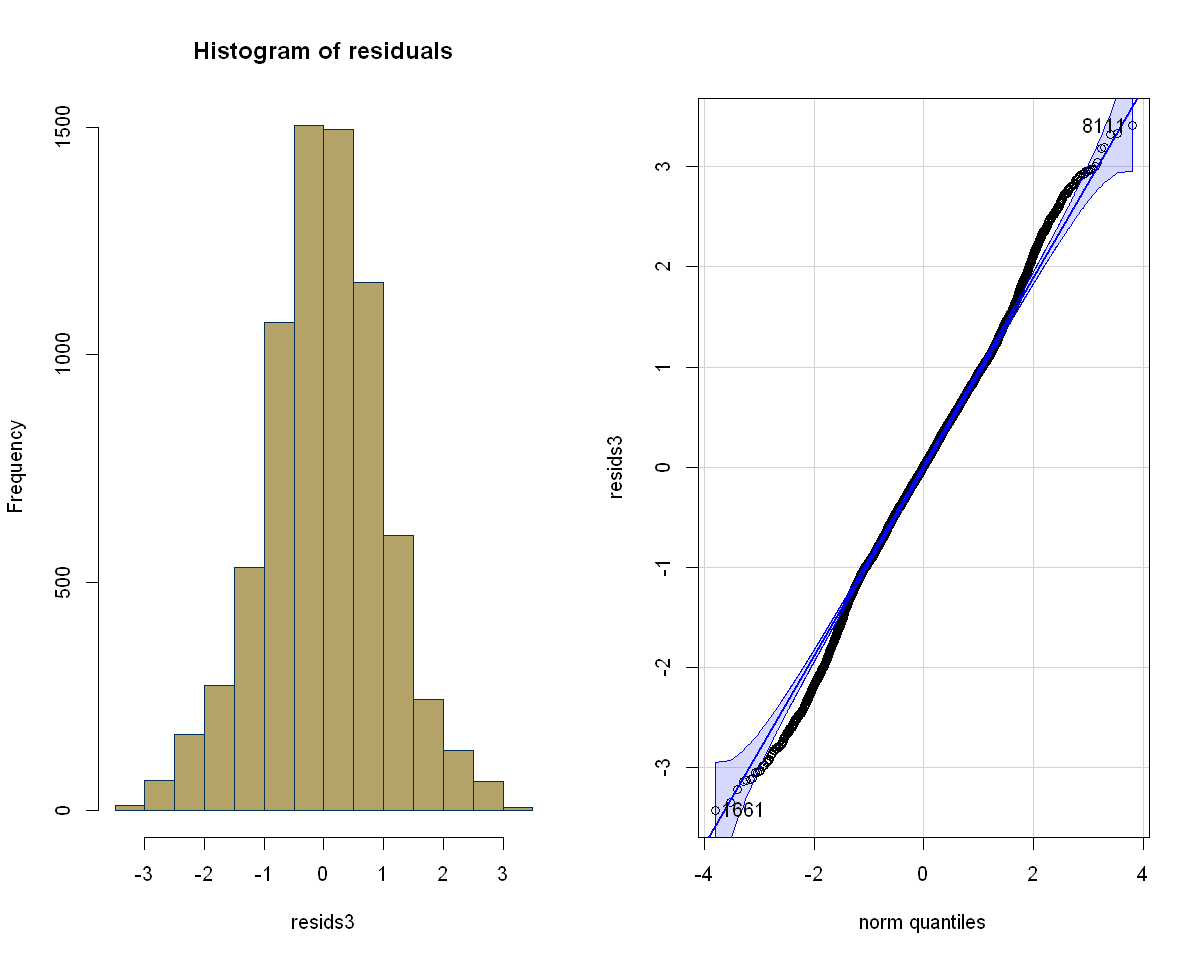

In [26]:
## Constant Variance Assumption
# Extract the standardized residuals
options(repr.plot.width = 10, repr.plot.height = 8)
resids3 = rstandard(model_3)
fits3 = model_3$fitted

# Plot the standardized residuals against fitted values
plot(fits3, resids3,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids3,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids3, envelope = 0.95)



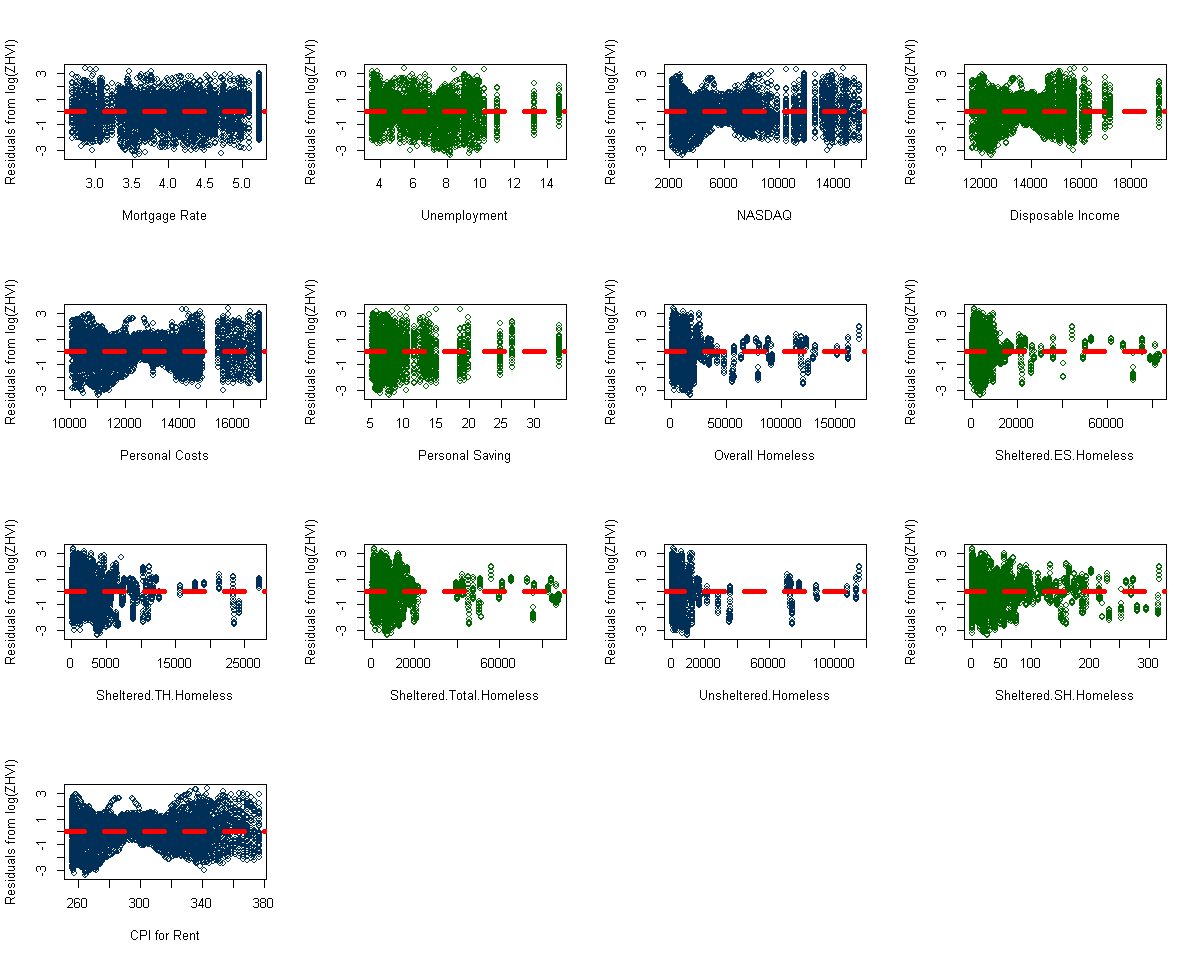

In [27]:
### Linearity Assumption
par(mfrow=c(4,4))
#options(repr.plot.width = 25, repr.plot.height = 25)

# Plot the standardized residuals against numeric variables

plot(trainData_cook$Mortgage_rate, resids3,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unemp_rate, resids3,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$NASDAQ, resids3,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$disposable_income, resids3,
     xlab="Disposable Income",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Personal_consumption_expenditure, resids3,
     xlab="Personal Costs",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$personal_savings, resids3,
     xlab="Personal Saving",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Overall.Homeless, resids3,
     xlab="Overall Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.ES.Homeless, resids3,
     xlab="Sheltered.ES.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.TH.Homeless, resids3,
     xlab="Sheltered.TH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.Total.Homeless, resids3,
     xlab="Sheltered.Total.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unsheltered.Homeless, resids3,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.SH.Homeless, resids3,
     xlab="Sheltered.SH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$CPI_Rent, resids3,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

options(repr.plot.width = 10, repr.plot.height = 8)

ah, much better on all fronts even if not perfect. Lets take it that the assumptions are met. Lets check for multicollinearity now:

In [28]:
#Multicollinearity
round(vif(model_3),3)

,GVIF,Df,GVIF^(1/(2*Df))
RegionName,6330.400,49,1.093
CPI,383.079,1,19.572
Mortgage_rate,2.147,1,1.465
Unemp_rate,10.460,1,3.234
NASDAQ,31.769,1,5.636
disposable_income,757.793,1,27.528
Personal_consumption_expenditure,1762.664,1,41.984
personal_savings,213.532,1,14.613
Unsheltered.Homeless,531073.780,1,728.748
Overall.Homeless,1623791.762,1,1274.281


oh wow, that is bad. some work is needed.

Lets perform some variable selection analysis( stepwise and ridge) to try work through this. 

#### Model 4: Stepwise determined MLR

In [29]:
set.seed(100) 
#Stepwise models
full = lm(log_ZHVI ~ RegionName + CPI + Mortgage_rate
                 + Unemp_rate + NASDAQ + disposable_income + Personal_consumption_expenditure + personal_savings
                 + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + CPI_Rent, 
          data=trainData_cook)  
minimum = lm(log_ZHVI ~ 1, data=trainData_cook)  

stepwise_forward = step(minimum, scope=list(lower=minimum, upper=full), direction="forward", trace = FALSE)
sf <- summary(stepwise_forward)
stepwise_backward = step(full, direction="backward", trace = FALSE)
sb <- summary(stepwise_backward)
stepwise_forward_backward = step(minimum, scope=list(lower=minimum, upper=full), direction = "both", trace = FALSE)
sfb <- summary(stepwise_forward_backward)

print('Stepwise Forward Results:')
stepwise_forward$call
AIC(stepwise_forward)
BIC(stepwise_forward)
print('Stepwise Backwards Results:')
stepwise_backward$call
AIC(stepwise_backward)
BIC(stepwise_backward)
print('Stepwise Forward Backwards Results:')
stepwise_forward_backward$call
AIC(stepwise_forward_backward)
BIC(stepwise_forward_backward)

[1] "Stepwise Forward Results:"


lm(formula = log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
    NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
    Unemp_rate + Overall.Homeless + personal_savings + Unsheltered.Homeless + 
    Personal_consumption_expenditure + CPI, data = trainData_cook)

[1] -21585.83

[1] -21151.18

[1] "Stepwise Backwards Results:"


lm(formula = log_ZHVI ~ RegionName + CPI + Mortgage_rate + Unemp_rate + 
    NASDAQ + disposable_income + Personal_consumption_expenditure + 
    Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + 
    Sheltered.TH.Homeless + CPI_Rent, data = trainData_cook)

[1] -21586.71

[1] -21158.96

[1] "Stepwise Forward Backwards Results:"


lm(formula = log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
    NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
    Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
    CPI, data = trainData_cook)

[1] -21586.71

[1] -21158.96

Forward yields a lower AIC and BIC (very marginally), therefore we will use it model as the model of choice from this selection process and call it model 4.  

In [30]:
#Run reg without outliers as Model 4:
model_4 = lm(log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
                NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
                Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
                CPI,
            data=trainData_cook)
m4_sum <- summary(model_4)
m4_sum


Call:
lm(formula = log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
    NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
    Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
    CPI, data = trainData_cook)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.187740 -0.034455  0.000626  0.035228  0.187168 

Coefficients:
                                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                       1.138e+01  3.305e-02  344.429  < 2e-16 ***
RegionNameAL                     -6.574e-01  6.535e-03 -100.596  < 2e-16 ***
RegionNameAR                     -7.528e-01  6.389e-03 -117.826  < 2e-16 ***
RegionNameAZ                     -1.553e-01  7.643e-03  -20.319  < 2e-16 ***
RegionNameCA                      1.215e+00  2.748e-02   44.235  < 2e-16 ***
RegionNameCO                      2.186e-01  7.394e-03   29.570  < 2e-16 ***
RegionNameCT                     -1.203e-01  6.654e

In [31]:
round(vif(model_4),3)

,GVIF,Df,GVIF^(1/(2*Df))
RegionName,6318.400,49,1.093
CPI_Rent,72.749,1,8.529
Sheltered.TH.Homeless,36304.740,1,190.538
NASDAQ,28.935,1,5.379
Mortgage_rate,1.948,1,1.396
Sheltered.ES.Homeless,397606.342,1,630.560
disposable_income,15.450,1,3.931
Unemp_rate,8.551,1,2.924
Overall.Homeless,1623185.165,1,1274.043
Unsheltered.Homeless,530878.600,1,728.614


Multicolinearity still a problem.

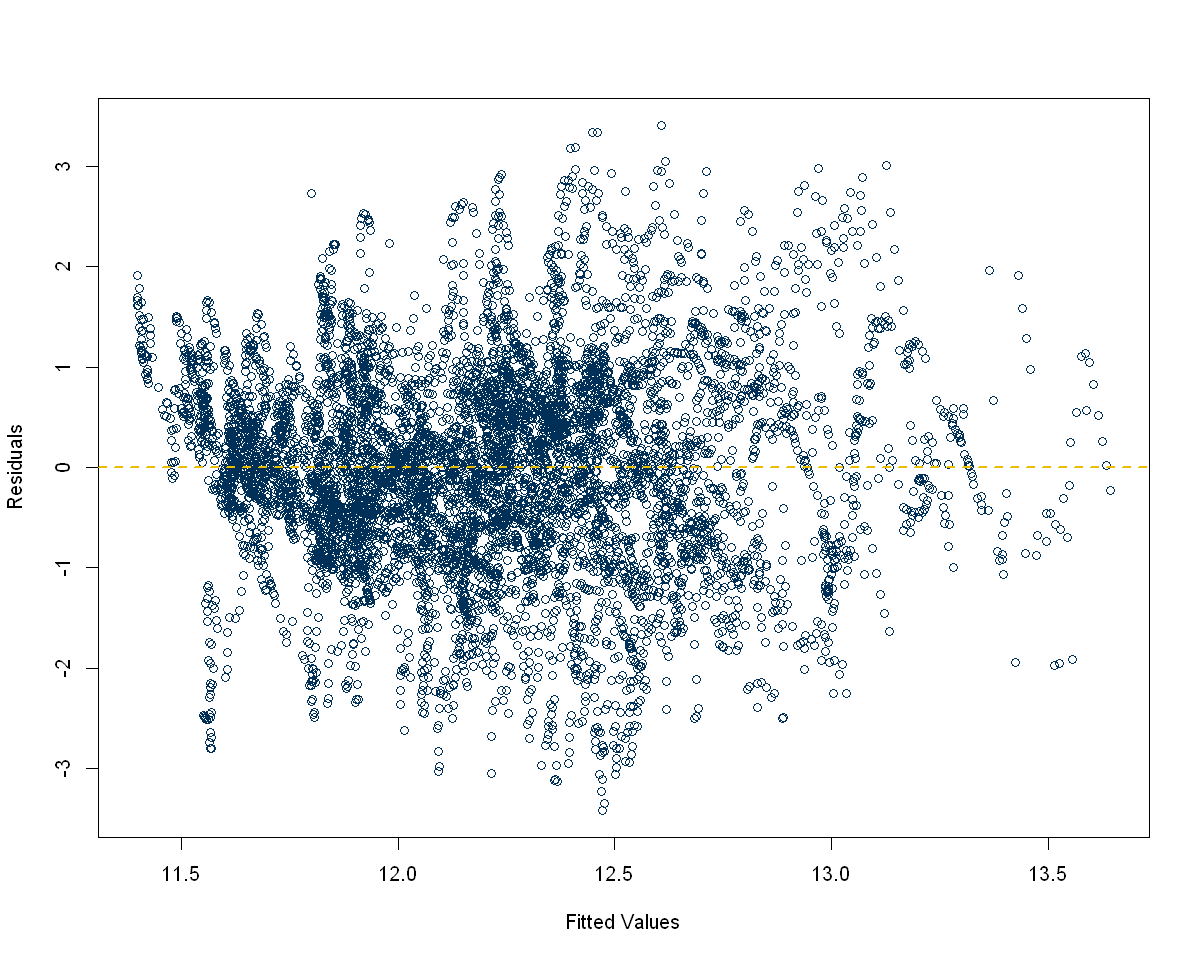

1661 8111 
 718 3787

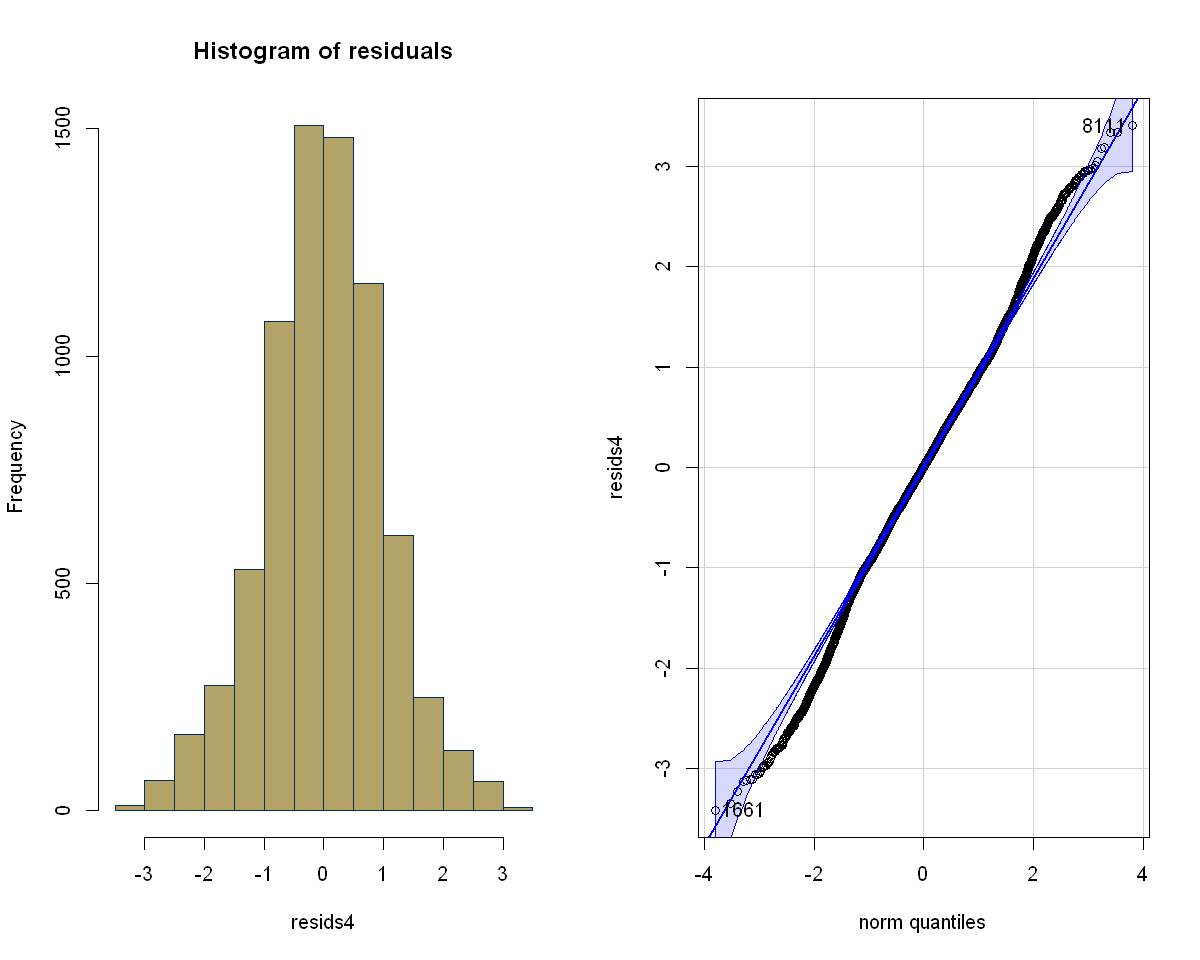

In [33]:
## Constant Variance Assumption
# Extract the standardized residuals
options(repr.plot.width = 10, repr.plot.height = 8)
resids4 = rstandard(model_4)
fits4 = model_4$fitted

# Plot the standardized residuals against fitted values
plot(fits4, resids4,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids4,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids4, envelope = 0.95)

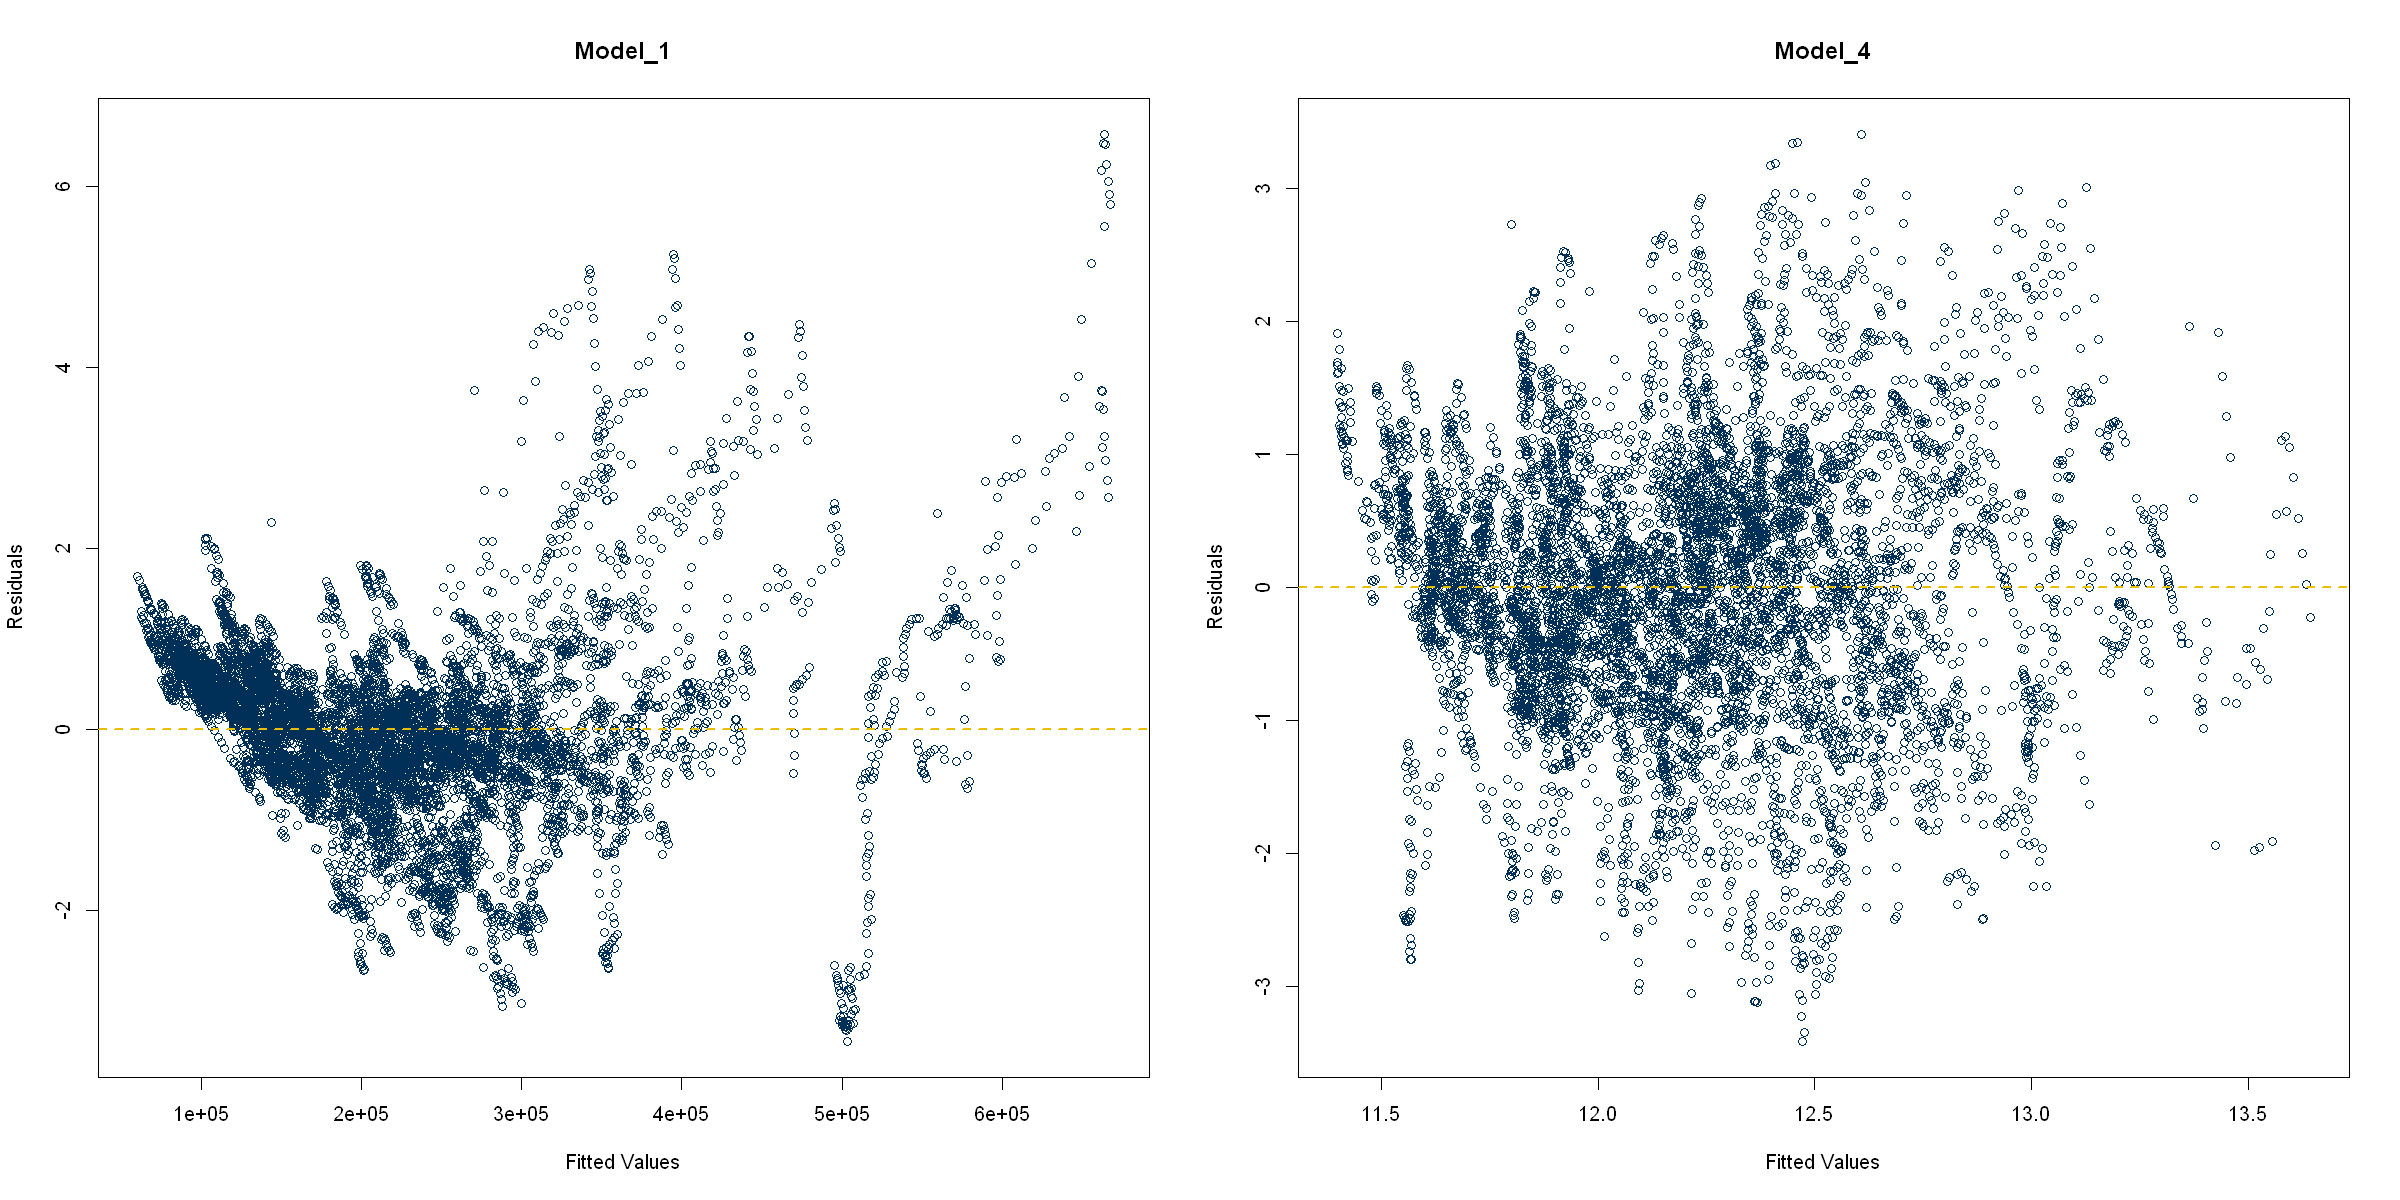

In [34]:
## Constant Variance Assumption
# Extract the standardized residuals
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow=c(1,2))

# Plot the standardized residuals against fitted values
plot(fits1, resids1,
     xlab="Fitted Values",
     ylab="Residuals",
     main="Model_1",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

# Plot the standardized residuals against fitted values
plot(fits4, resids4,
     xlab="Fitted Values",
     ylab="Residuals",
     main="Model_4",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)



3593 3592 
1711 1710

1661 8111 
 718 3787

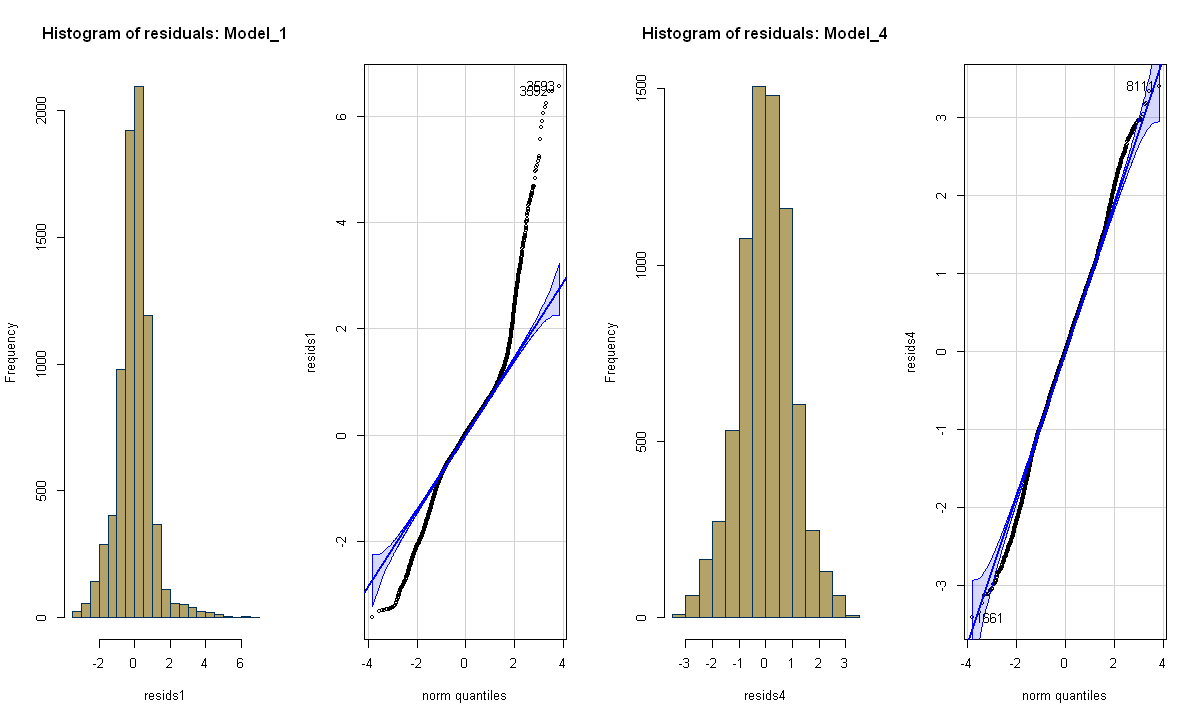

In [35]:
### Normality Assumption
options(repr.plot.width = 10, repr.plot.height = 6)
par(mfrow=c(1,4))

# Plot histogram of std residuals for MR
hist(resids1,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals: Model_1")

# qq plot of std residuals
qqPlot(resids1, envelope = 0.95)



### Normality Assumption

# Plot histogram of std residuals for MR
hist(resids4,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals: Model_4")

# qq plot of std residuals
qqPlot(resids4, envelope = 0.95)

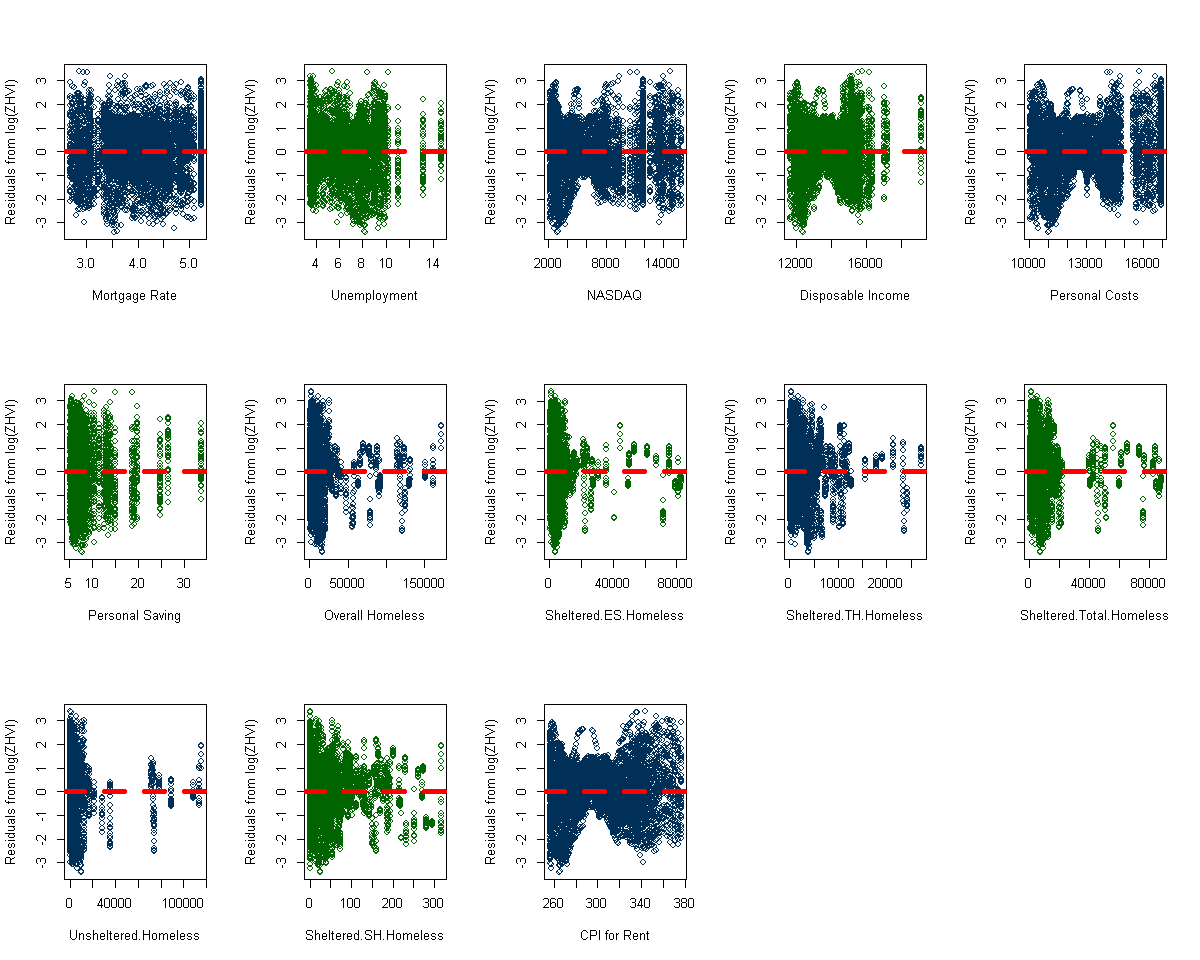

In [36]:
### Linearity Assumption
par(mfrow=c(3,5))
options(repr.plot.width = 25, repr.plot.height = 25)

# Plot the standardized residuals against numeric variables

plot(trainData_cook$Mortgage_rate, resids4,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unemp_rate, resids4,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$NASDAQ, resids4,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$disposable_income, resids4,
     xlab="Disposable Income",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Personal_consumption_expenditure, resids4,
     xlab="Personal Costs",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$personal_savings, resids4,
     xlab="Personal Saving",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Overall.Homeless, resids4,
     xlab="Overall Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.ES.Homeless, resids3,
     xlab="Sheltered.ES.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.TH.Homeless, resids4,
     xlab="Sheltered.TH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.Total.Homeless, resids4,
     xlab="Sheltered.Total.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unsheltered.Homeless, resids4,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Sheltered.SH.Homeless, resids4,
     xlab="Sheltered.SH.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$CPI_Rent, resids4,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

options(repr.plot.width = 10, repr.plot.height = 8)

#### Model 5: Ridge Regression

In [37]:
# Ridge Regression

set.seed(100) 
y <- trainData_cook$log_ZHVI
xx <- trainData_cook[,-c(2,3,4,12)]
x <- model.matrix(log_ZHVI ~ ., data = xx)[, -1]

ridge_cv <- cv.glmnet(x, y, alpha = 0, nfolds = 10)
lambda_cv <- ridge_cv$lambda.min

model_5 <- glmnet(x, y, alpha = 0, nlambda = 100) #auto-scales data
coef(model_5, lambda_cv)


65 x 1 sparse Matrix of class "dgCMatrix"
                                            s1
(Intercept)                       1.070988e+01
RegionNameAL                     -4.239382e-01
RegionNameAR                     -4.980548e-01
RegionNameAZ                      7.449639e-03
RegionNameCA                      6.299854e-01
RegionNameCO                      3.557381e-01
RegionNameCT                      9.211551e-02
RegionNameDE                      9.927883e-02
RegionNameDISTRICT OF COLUMBIA    .           
RegionNameFL                     -9.403102e-02
RegionNameGA                     -2.786716e-01
RegionNameHI                      8.432833e-01
RegionNameIA                     -4.516538e-01
RegionNameID                     -5.516313e-02
RegionNameIL                     -2.201248e-01
RegionNameIN                     -4.758747e-01
RegionNameKS                     -4.894976e-01
RegionNameKY                     -5.656982e-01
RegionNameLA                     -2.538360e-01
RegionNameMA      

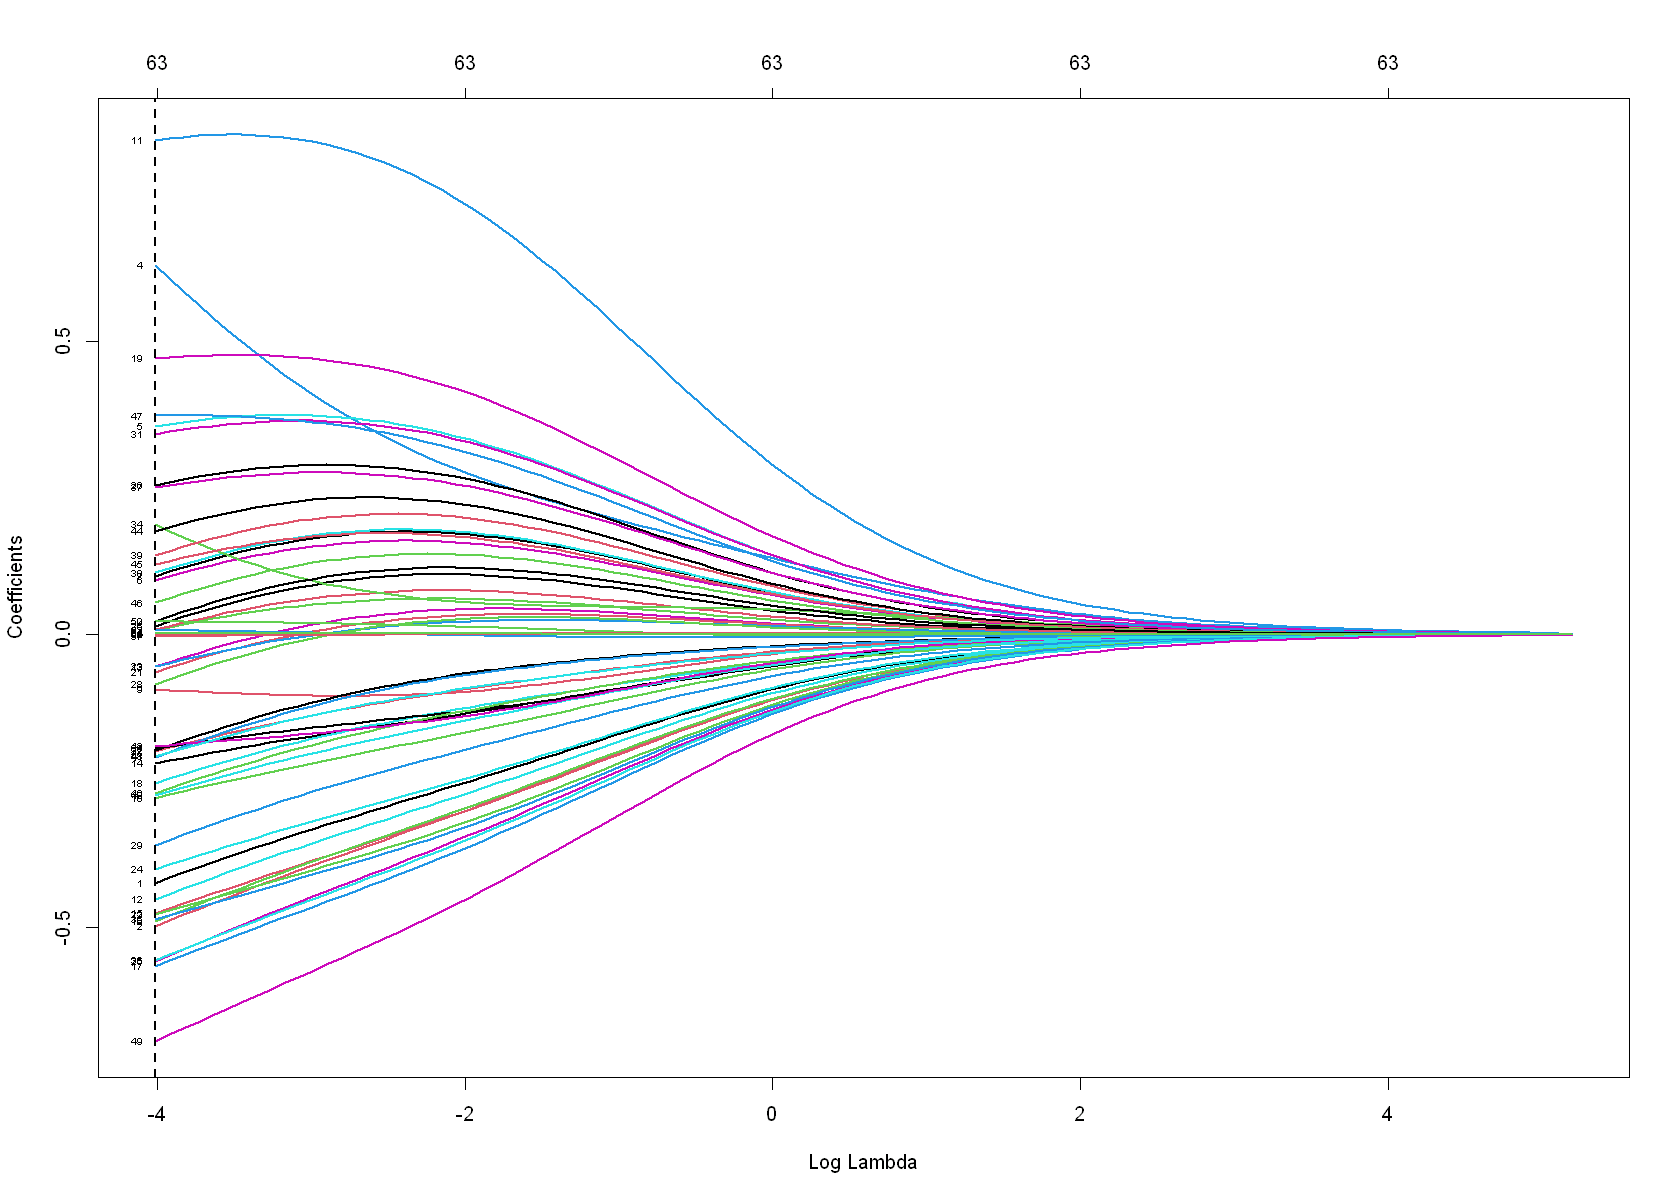

In [38]:
options(repr.plot.width = 14, repr.plot.height = 10)
plot(model_5, xvar = 'lambda', label = TRUE, lwd = 2)
abline(v = log(lambda_cv), col = 'black', lty = 2, lwd = 2)

The data is panel data so it would be worthwhile attempting pooled regressions even if they are beyond the scope of the course. 

#### Model 6: Panel Reg ("within") Fixed Effect

In [39]:
## This is Panel Data so lets also look at a panel data model:
#Step 1: represent data as panel data:
traindataPanel <- trainData_cook

# Convert data frame to panel data frame
traindataPanel <- pdata.frame(traindataPanel, index = c("RegionName", "date"))
head(traindataPanel, 1)

,RegionName,date,ZHVI,year_month,CPI,Mortgage_rate,Unemp_rate,NASDAQ,disposable_income,Personal_consumption_expenditure,personal_savings,Year,Overall.Homeless,Sheltered.ES.Homeless,Sheltered.TH.Homeless,Sheltered.Total.Homeless,Unsheltered.Homeless,Sheltered.SH.Homeless,CPI_Rent,log_ZHVI
,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AK-2010-01-31,AK,2010-01-31,246485.1,2010-01,217.488,5.03,9.8,2267.775,11644.6,10056.1,5.9,2010,1863,1013,658,1671,192,0,256.425,12.41506


In [40]:
#Create models with different effects - Fixed Effect (within) using the stepwise variables
model_6 <- plm(log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
                NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
                Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
                CPI, 
                data = traindataPanel, model = "within")
m6_sum <- summary(model_6)
m6_sum

Oneway (individual) effect Within Model

Call:
plm(formula = log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
    NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
    Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
    CPI, data = traindataPanel, model = "within")

Unbalanced Panel: n = 50, T = 78-156, N = 7327

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.18774042 -0.03445452  0.00062583  0.03522805  0.18716805 

Coefficients:
                                    Estimate  Std. Error  t-value  Pr(>|t|)    
CPI_Rent                          3.7628e-03  1.7155e-04  21.9343 < 2.2e-16 ***
Sheltered.TH.Homeless             1.5983e-04  3.9579e-05   4.0383 5.439e-05 ***
NASDAQ                            1.4831e-05  9.6352e-07  15.3920 < 2.2e-16 ***
Mortgage_rate                     2.3643e-02  1.4910e-03  15.8575 < 2.2e-16 ***
Sheltered.ES.Homeless             1.8416e-04  3.9655e-05   4.64

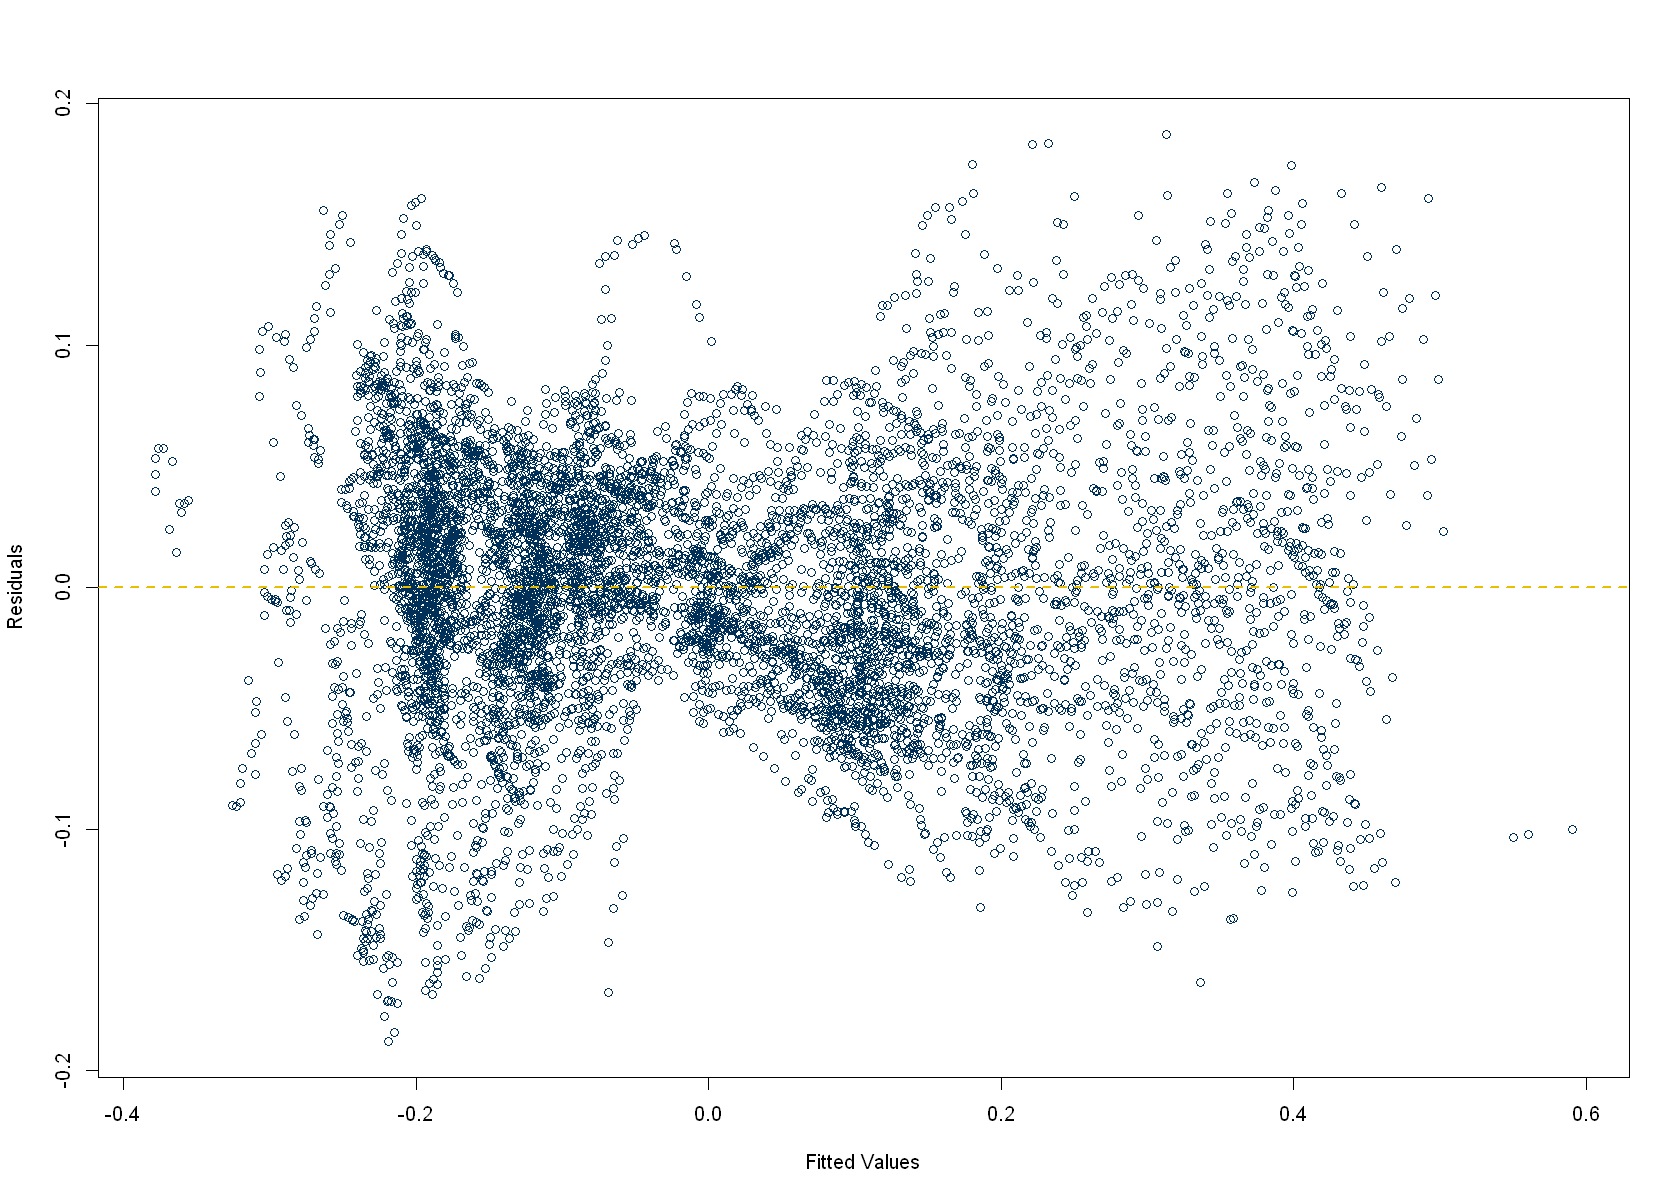

[1]  718 3787

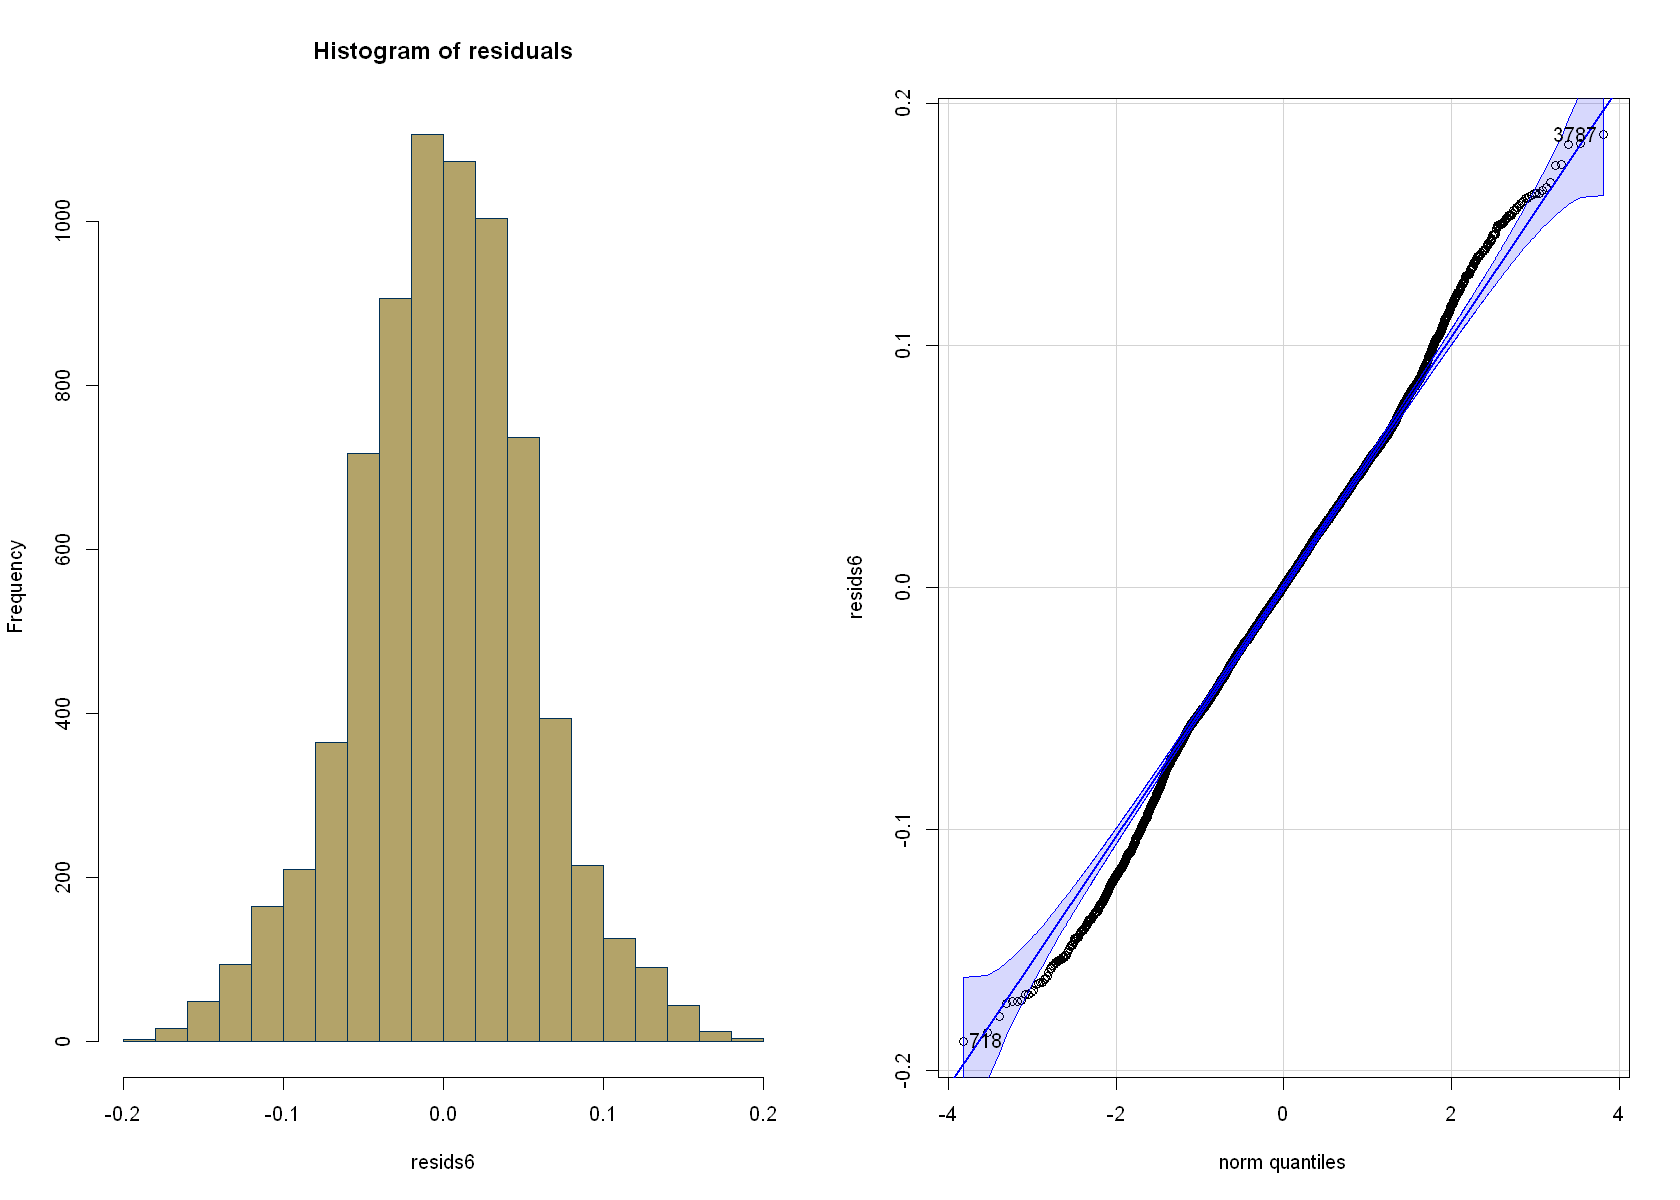

In [41]:
#options(repr.plot.width = 10, repr.plot.height = 8)
resids6 = as.numeric(residuals(model_6))
fits6 = as.numeric(fitted(model_6))


# Plot the standardized residuals against fitted values
plot(fits6, resids6,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids6,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids6, envelope = 0.95)

#### Model 7: Pooled Panel Reg 

In [42]:
#Create models with different effects - Pooled OLS which should yield similar results as normal reg
model_7 <- plm(log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
                NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
                Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
                CPI, 
                data = traindataPanel, model = "pooling")
m7_sum <- summary(model_7)
m7_sum

Pooling Model

Call:
plm(formula = log_ZHVI ~ RegionName + CPI_Rent + Sheltered.TH.Homeless + 
    NASDAQ + Mortgage_rate + Sheltered.ES.Homeless + disposable_income + 
    Unemp_rate + Overall.Homeless + Unsheltered.Homeless + Personal_consumption_expenditure + 
    CPI, data = traindataPanel, model = "pooling")

Unbalanced Panel: n = 50, T = 78-156, N = 7327

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.18774042 -0.03445452  0.00062583  0.03522805  0.18716805 

Coefficients:
                                    Estimate  Std. Error   t-value  Pr(>|t|)
(Intercept)                       1.1385e+01  3.3054e-02  344.4286 < 2.2e-16
RegionNameAL                     -6.5738e-01  6.5348e-03 -100.5956 < 2.2e-16
RegionNameAR                     -7.5278e-01  6.3890e-03 -117.8260 < 2.2e-16
RegionNameAZ                     -1.5529e-01  7.6429e-03  -20.3188 < 2.2e-16
RegionNameCA                      1.2155e+00  2.7478e-02   44.2347 < 2.2e-16
RegionNameCO              

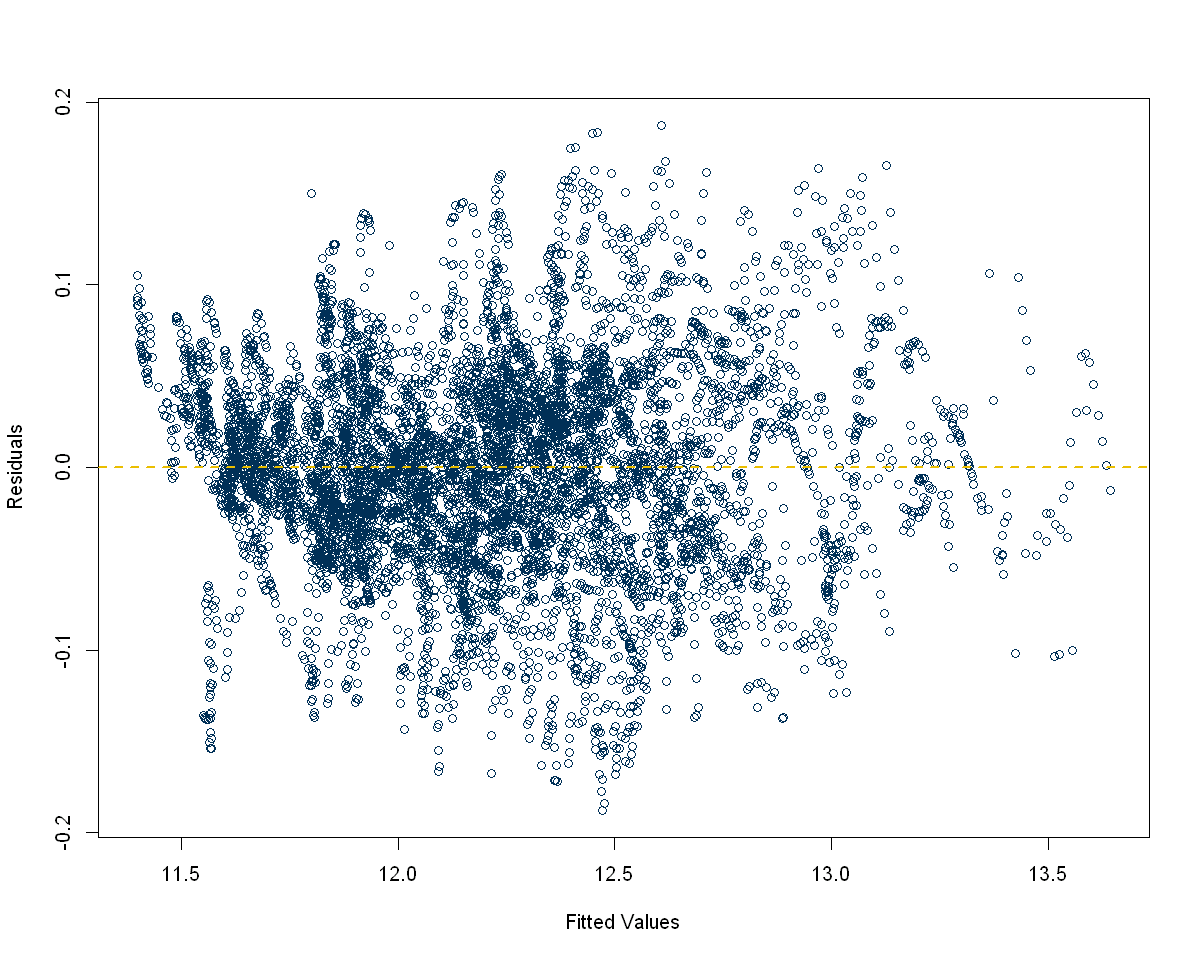

[1]  718 3787

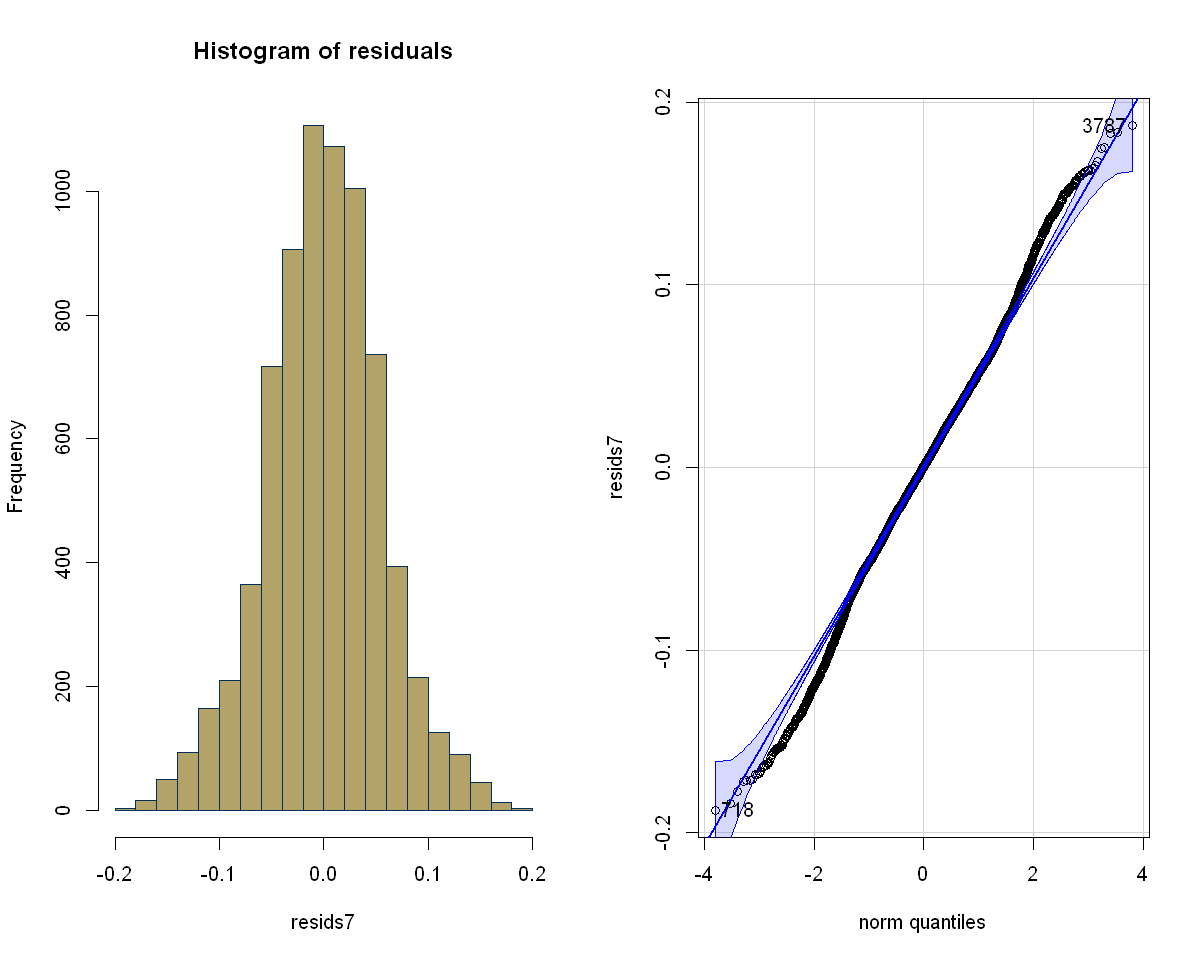

In [43]:
options(repr.plot.width = 10, repr.plot.height = 8)
resids7 = as.numeric(residuals(model_7))
fits7 = as.numeric(fitted(model_7))


# Plot the standardized residuals against fitted values
plot(fits7, resids7,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids7,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids7, envelope = 0.95)


#### Model 8: Simplification 

Given th nature of the variables and the levels of multicollinearity, so interrogation gives rise to a intuative model build where variables that overlap in terms of impact are dropped from model 3.

Reduce the model down to one Homeless field as all linked (focus on Homeless unsheltered), drop CPI as CPI rent is a component of the overall rent and is the component we are most interested in. Also drop personal_saving as it is not significant and has overlap with other fields we look to drop: Personal_consumption_expenditure and disposable-income as they all move in the same direction and are heavily linked to NASDAQ as a better performing market typically indicates a better performing economy which ties back to more diposable income and, hence, more spending.

The main purpose of this approach is to simplify while keeping easy of intepretting. However, a partial F-test is necessary to determine if the approach has merit.

In [44]:
model_8 = lm(log_ZHVI ~ RegionName + Mortgage_rate + Unemp_rate + NASDAQ + Unsheltered.Homeless + CPI_Rent,
            data=trainData_cook)
m8_sum <- summary(model_8)
m8_sum


Call:
lm(formula = log_ZHVI ~ RegionName + Mortgage_rate + Unemp_rate + 
    NASDAQ + Unsheltered.Homeless + CPI_Rent, data = trainData_cook)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.230673 -0.036916 -0.000041  0.038957  0.215458 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           1.113e+01  2.144e-02  519.344  < 2e-16 ***
RegionNameAL         -6.886e-01  7.094e-03  -97.069  < 2e-16 ***
RegionNameAR         -7.544e-01  7.094e-03 -106.348  < 2e-16 ***
RegionNameAZ         -2.465e-01  7.767e-03  -31.730  < 2e-16 ***
RegionNameCA          4.778e-01  1.915e-02   24.952  < 2e-16 ***
RegionNameCO          1.181e-01  7.439e-03   15.880  < 2e-16 ***
RegionNameCT         -1.390e-01  7.352e-03  -18.909  < 2e-16 ***
RegionNameDE         -1.335e-01  7.090e-03  -18.825  < 2e-16 ***
RegionNameFL         -3.637e-01  8.420e-03  -43.188  < 2e-16 ***
RegionNameGA         -5.318e-01  7.333e-03  -72.526  < 2e-16 ***
RegionNameHI 

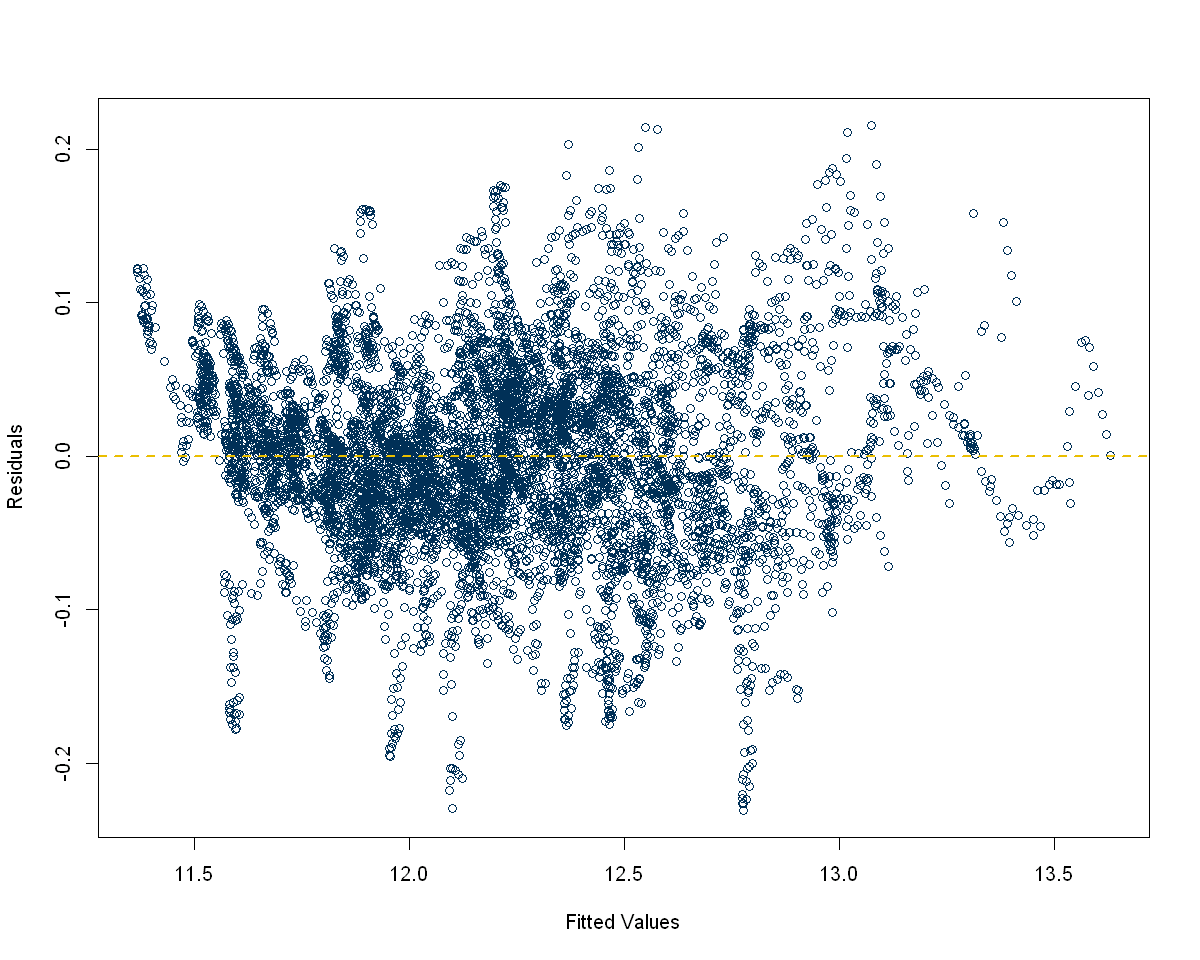

[1]  593 4696

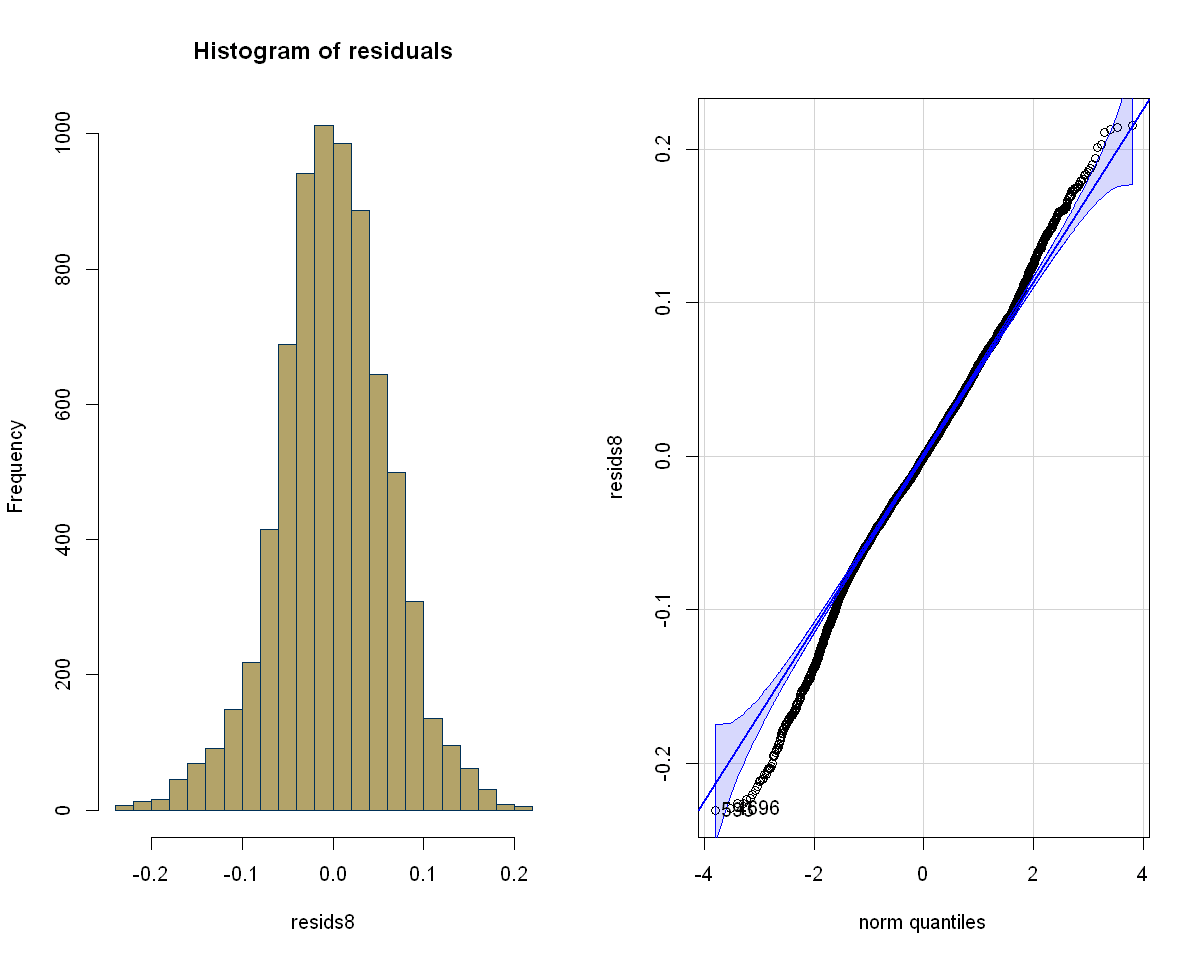

In [45]:
options(repr.plot.width = 10, repr.plot.height = 8)
resids8 = as.numeric(residuals(model_8))
fits8 = as.numeric(fitted(model_8))


# Plot the standardized residuals against fitted values
plot(fits8, resids8,
     xlab="Fitted Values",
     ylab="Residuals",
     main="",
     col=gtblue)
abline(0, 0, 
       col=buzzgold, 
       lty=2, lwd=2)

### Normality Assumption
par(mfrow=c(1,2))
# Plot histogram of std residuals for MR
hist(resids8,
     nclass=20,
     col=techgold,
     border=gtblue,
     main="Histogram of residuals")

# qq plot of std residuals
qqPlot(resids8, envelope = 0.95)

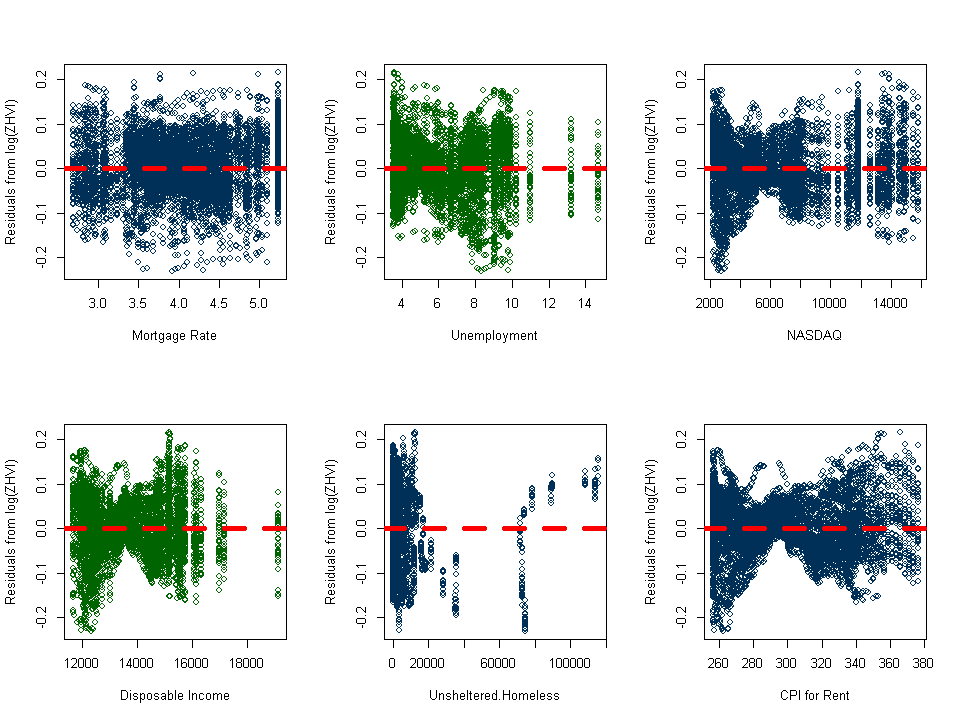

In [46]:
### Linearity Assumption
par(mfrow=c(2,3))

options(repr.plot.width = 8, repr.plot.height = 6)
# Plot the standardized residuals against numeric variables

plot(trainData_cook$Mortgage_rate, resids8,
     xlab="Mortgage Rate",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unemp_rate, resids8,
     xlab="Unemployment",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$NASDAQ, resids8,
     xlab="NASDAQ",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$disposable_income, resids8,
     xlab="Disposable Income",
     ylab="Residuals from log(ZHVI)",
     main="",
     col='dark green')
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$Unsheltered.Homeless, resids8,
     xlab="Unsheltered.Homeless",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)

plot(trainData_cook$CPI_Rent, resids8,
     xlab="CPI for Rent",
     ylab="Residuals from log(ZHVI)",
     main="",
     col=gtblue)
abline(0, 0, 
       col='red', 
       lty=2, lwd=4)



In [47]:
options(repr.plot.width = 10, repr.plot.height = 8)

Similar results to previous models so let say assumptions are passed. Now however, we need to do an F-partial to see if the model can be used.

In [48]:
# Using anova(reduced model, full model) to perform partial F-test
partial_f_test <- anova(model_3, model_8)
partial_f_test
# Extract the F-value and p-value
f_value <- partial_f_test$`F`[2]
p_value <- partial_f_test$`Pr(>F)`[2]

# Print the F-value and p-value
print(paste("F-value:", f_value))
print(paste("p-value:", p_value))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7265,22.15760,NA,NA,NA,NA
2,7272,27.35949,-7,-5.201882,243.655,0


[1] "F-value: 243.654963566446"
[1] "p-value: 0"


Since the p-value from the partial F-test is less than the alpha level of 0.05, it means that the additional predictors in model_3 do significantly improve the model compared to model_8. In other words, there is enough evidence to reject the null hypothesis, which states that the simpler model (model_8) is sufficient and the additional predictors in model_3 don't provide a statistically significant improvement. Therefore, we will not use model_8.

#### Model 9: Elastic Net

In [49]:
set.seed(100) #this seed has been set to 100 in all cells to ensure results are reproducible. DO NOT CHANGE THIS SEED
# Perform Elastic Net with cross-validation to find the optimal lambda perform 10 fold cv
cv_elastic_net_model <- cv.glmnet(x, y, alpha = 0.5, nfolds = 10, family = 'gaussian')

# Optimal lambda from cross-validation
elastic_net_lambda <- cv_elastic_net_model$lambda.min

cat("Optimal lambda:", round(elastic_net_lambda, 4), "\n")


Optimal lambda: 1e-04 


In [50]:
set.seed(100) #this seed has been set to 100 in all cells to ensure results are reproducible. DO NOT CHANGE THIS SEED
model_9 <- glmnet(x, y, family = 'gaussian', alpha = 0.5, nlambda = 100)
coef(model_9, s = cv_elastic_net_model$lambda.min)

65 x 1 sparse Matrix of class "dgCMatrix"
                                            s1
(Intercept)                       1.108610e+01
RegionNameAL                     -6.363333e-01
RegionNameAR                     -7.308713e-01
RegionNameAZ                     -1.373372e-01
RegionNameCA                      1.193193e+00
RegionNameCO                      2.347434e-01
RegionNameCT                     -9.982340e-02
RegionNameDE                     -1.159824e-01
RegionNameDISTRICT OF COLUMBIA    .           
RegionNameFL                     -6.024689e-02
RegionNameGA                     -4.167493e-01
RegionNameHI                      7.011932e-01
RegionNameIA                     -6.702091e-01
RegionNameID                     -2.716411e-01
RegionNameIL                     -3.395626e-01
RegionNameIN                     -6.723869e-01
RegionNameKS                     -7.186999e-01
RegionNameKY                     -7.783920e-01
RegionNameLA                     -4.535756e-01
RegionNameMA      

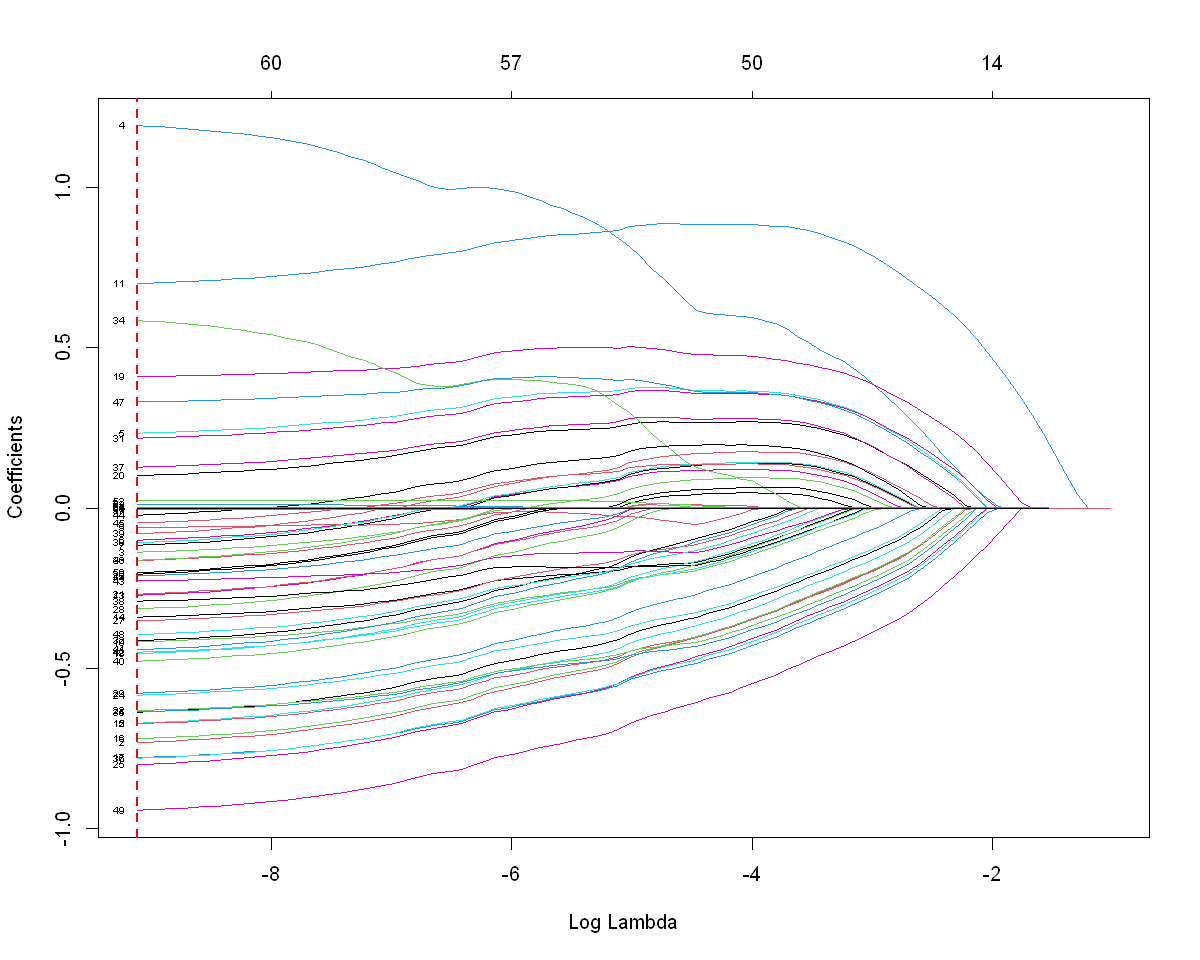

In [51]:
set.seed(100) #this seed has been set to 100 in all cells to ensure results are reproducible. DO NOT CHANGE THIS SEED
plot(model_9, xvar = "lambda", label = TRUE)
abline(v = log(cv_elastic_net_model$lambda.min), col = "red", lty = 2, lwd = 2)

### Model Summary

In [52]:
# Print Adjusted R-squared for each MLR model
adj_r2_model1 <- summary(model_1)$adj.r.squared
print(paste("Adjusted R-squared for model1:", adj_r2_model1))
adj_r2_model2 <- summary(model_2)$adj.r.squared
print(paste("Adjusted R-squared for model2:", adj_r2_model2))
adj_r2_model3 <- summary(model_3)$adj.r.squared
print(paste("Adjusted R-squared for model3:", adj_r2_model3))
adj_r2_model4 <- summary(model_4)$adj.r.squared
print(paste("Adjusted R-squared for model4:", adj_r2_model4))
#adj_r2_model5 <- summary(model_5)$adj.r.squared
#print(paste("Adjusted R-squared for model5:", adj_r2_model5))
adj_r2_model6 <- summary(model_6)$r.squared["adjrsq"]
print(paste("Adjusted R-squared for model6:", adj_r2_model6))
adj_r2_model7 <- summary(model_7)$r.squared["adjrsq"]
print(paste("Adjusted R-squared for model7:", adj_r2_model7))
adj_r2_model8 <- summary(model_8)$adj.r.squared
print(paste("Adjusted R-squared for model8:", adj_r2_model8))

[1] "Adjusted R-squared for model1: 0.926786915277861"
[1] "Adjusted R-squared for model2: 0.966633513205583"
[1] "Adjusted R-squared for model3: 0.981153815749444"
[1] "Adjusted R-squared for model4: 0.981153531715918"
[1] "Adjusted R-squared for model6: 0.920107569379464"
[1] "Adjusted R-squared for model7: 0.98115353171592"
[1] "Adjusted R-squared for model8: 0.976751747395649"


Lets cull the other models and focus on 3,4 and 5 (6, 7 are pooled data is out of scope). Lets focus on the predicting ability of the other models.

### Prediction

In [54]:
# Build a prediction of the models with the new test data
# Specify whether a confidence or prediction interval
testData$log_ZHVI <- log(testData$ZHVI)
pred_model1 = predict(model_1, testData, interval = 'prediction')
test.pred1 = pred_model1[,1]
test.lwr1 = pred_model1[,2]
test.upr1 = pred_model1[,3]

pred_model2 = predict(model_2, testData, interval = 'prediction')
test.pred2 = pred_model2[,1]
test.lwr2 = pred_model2[,2]
test.upr2 = pred_model2[,3]

pred_model3 = predict(model_3, testData, interval = 'prediction')
test.pred3 = pred_model3[,1]
test.lwr3 = pred_model3[,2]
test.upr3 = pred_model3[,3]

pred_model4 = predict(model_4, testData, interval = 'prediction')
test.pred4 = pred_model4[,1]
test.lwr4 = pred_model4[,2]
test.upr4 = pred_model4[,3]

pred_model8 = predict(model_8, testData, interval = 'prediction')
test.pred8 = pred_model8[,1]
test.lwr8 = pred_model8[,2]
test.upr8 = pred_model8[,3]


In [56]:
## Prediction measure functions
# Mean Squared Prediction Error (MSPE)
mse_fun <- function(pred,dat){mean((pred-dat)^2)}
cat('MSPE for model 1:', mse_fun(test.pred1,testData$ZHVI),'\n')
cat('MSPE for model 2:', mse_fun(test.pred2,testData$log_ZHVI),'\n')
cat('MSPE for model 3:', mse_fun(test.pred3,testData$log_ZHVI),'\n')
cat('MSPE for model 4:', mse_fun(test.pred4,testData$log_ZHVI),'\n')
cat('MSPE for model 8:', mse_fun(test.pred8,testData$log_ZHVI),'\n')


# Mean Absolute Prediction Error (MAE)
mae_fun <- function(pred,dat){mean(abs(pred-dat))}
cat('MAE for model 1:', mae_fun(test.pred1,testData$ZHVI),'\n')
cat('MAE for model 2:', mae_fun(test.pred2,testData$log_ZHVI),'\n')
cat('MAE for model 3:', mae_fun(test.pred3,testData$log_ZHVI),'\n')
cat('MAE for model 4:', mae_fun(test.pred4,testData$log_ZHVI),'\n')
cat('MAE for model 8:', mae_fun(test.pred8,testData$log_ZHVI),'\n')

# Mean Absolute Percentage Error (MAPE)
mape_fun <- function(pred,dat){mean(abs(pred-dat)/abs(dat))}
cat('MAPE for model 1:',mape_fun(test.pred1,testData$ZHVI),'\n')
cat('MAPE for model 2:',mape_fun(test.pred2,testData$log_ZHVI),'\n')
cat('MAPE for model 3:',mape_fun(test.pred3,testData$log_ZHVI),'\n')
cat('MAPE for model 4:',mape_fun(test.pred4,testData$log_ZHVI),'\n')
cat('MAPE for model 8:',mape_fun(test.pred8,testData$log_ZHVI),'\n')


# Precision Measure (PM)
pm_fun <- function(pred,dat){sum((pred-dat)^2)/sum((dat-mean(dat))^2) }
cat('Precision Measure for model 1:',pm_fun(test.pred1,testData$ZHVI),'\n')
cat('Precision Measure for model 2:',pm_fun(test.pred2,testData$log_ZHVI),'\n')
cat('Precision Measure for model 3:',pm_fun(test.pred3,testData$log_ZHVI),'\n')
cat('Precision Measure for model 4:',pm_fun(test.pred4,testData$log_ZHVI),'\n')
cat('Precision Measure for model 8:',pm_fun(test.pred8,testData$log_ZHVI),'\n')

       
# CI Measure (CIM)
ci_fun <- function(pred.lwr,pred.upr,dat){
  sum(dat<pred.lwr|dat>pred.upr)/length(dat) 
}
cat('CI measure for model 1:',ci_fun(test.lwr1,test.upr1, testData$ZHVI),'\n')
cat('CI measure for model 2:',ci_fun(test.lwr2,test.upr2, testData$log_ZHVI),'\n')
cat('CI measure for model 3:',ci_fun(test.lwr3,test.upr3, testData$log_ZHVI),'\n')
cat('CI measure for model 4:',ci_fun(test.lwr4,test.upr4, testData$log_ZHVI),'\n')
cat('CI measure for model 8:',ci_fun(test.lwr8,test.upr8, testData$log_ZHVI),'\n')

MSPE for model 1: 2928376729 
MSPE for model 2: 0.01547903 
MSPE for model 3: 0.01479991 
MSPE for model 4: 0.01477196 
MSPE for model 8: 0.01507609 
MAE for model 1: 45055.11 
MAE for model 2: 0.09932511 
MAE for model 3: 0.09577564 
MAE for model 4: 0.09568282 
MAE for model 8: 0.0977639 
MAPE for model 1: 0.1471433 
MAPE for model 2: 0.007878739 
MAPE for model 3: 0.007572877 
MAPE for model 4: 0.007565207 
MAPE for model 8: 0.007732108 
Precision Measure for model 1: 0.1505361 
Precision Measure for model 2: 0.1079866 
Precision Measure for model 3: 0.1032489 
Precision Measure for model 4: 0.1030539 
Precision Measure for model 8: 0.1051756 
CI measure for model 1: 0.3233333 
CI measure for model 2: 0.2083333 
CI measure for model 3: 0.3433333 
CI measure for model 4: 0.3433333 
CI measure for model 8: 0.32 


In [57]:
#Ridge regression model_5 

#convert test data to matrix that will be used in ridge regression prediction
xx_en <- testData[,-c(2,3,4,12)]
y_test <- testData$log_ZHVI
testdata=model.matrix(log_ZHVI ~ ., xx_en)[, -1]

#Ridge regression model
print('Ridge regression model:')

predict_ridge = predict(model_5, newx = testdata, s = ridge_cv$lambda.min, type = "response")
colnames(predict_ridge) <- "Ridge"
mean(predict_ridge)

[1] "Ridge regression model:"


[1] 12.66512

In [58]:
#9
#Elastic Net model from question 4d
predict_elastic_net <- predict(model_9, newx = testdata, s = elastic_net_lambda, type = "response")
colnames(predict_elastic_net) <- "ElasticNet"
print('Elastic Net model:')
mean(predict_elastic_net)

[1] "Elastic Net model:"


[1] 12.70829

In [59]:

# Ridge
mspe_ridge <- mean((y_test - predict_ridge)^2)
rmse_ridge <- sqrt(mspe_ridge)
mae_ridge <- mean(abs(y_test - predict_ridge))

# Elastic Net
mspe_elastic <- mean((y_test - predict_elastic_net)^2)
rmse_elastic <- sqrt(mspe_elastic)
mae_elastic <- mean(abs(y_test - predict_elastic_net))

In [60]:
mspe_ridge 
rmse_ridge 
mae_ridge 

[1] 0.01347403

[1] 0.1160777

[1] 0.08832397

In [61]:
mspe_elastic 
rmse_elastic 
mae_elastic 

[1] 0.01424485

[1] 0.1193518

[1] 0.09415585

In [62]:
cat('RMSE for model 1:', sqrt(mse_fun(test.pred1,testData$ZHVI))/mean(testData$ZHVI),'\n')
cat('RMSE for model 2:', sqrt(mse_fun(test.pred2,testData$log_ZHVI)),'\n')
cat('RMSE for model 3:', sqrt(mse_fun(test.pred3,testData$log_ZHVI)),'\n')
cat('RMSE for model 4:', sqrt(mse_fun(test.pred4,testData$log_ZHVI)),'\n')
cat('RMSE for model 8:', sqrt(mse_fun(test.pred8,testData$log_ZHVI)),'\n')


RMSE for model 1: 0.1563849 
RMSE for model 2: 0.1244147 
RMSE for model 3: 0.1216549 
RMSE for model 4: 0.12154 
RMSE for model 8: 0.1227847 
